In [1]:
#from IPython.core.display import clear_output

#!pip3 install pandas-profiling==2.11
#clear_output()

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
#! cp /content/drive/MyDrive/semester7/Thesis/Models/* ./ -r
#! cp /content/drive/MyDrive/semester7/Thesis/Datasets/* ./ -r

In [3]:
#!gdown 1YHqgEFHoXa5vpSfKteAhBUWsJJ2RHgS7 -O data.csv

In [4]:
#cd D:\Учеба\7 semester\Models_paper
import os
os.chdir("/home/danil-pass123/Документы/Repos/FederatedLearning")

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
#from pandas_profiling import ProfileReport

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import minmax_scale

from Datasets.ProcessDataset import Dataset

#import torch
from sklearn.model_selection import train_test_split

from Models.Optimisers.GD import StochasticGradientDescent
from Models.Optimisers.Adam import Adam

from Models.Preconditioners.Preconditioners import SGD_preconditioner,Adam_preconditioner,OASIS_preconditioner

#from Models.LogisticRegression.LogisticRegression import Logistic_Regression
#from Models.LogisticRegression.LogisticRegression_layer import Logistic_Regression_train
from Models.LogisticRegression.LogisticRegression_numpy import Logistic_Regression_numpy
from Models.LogisticRegression.LogisticRegression_sklearn import Logistic_Regression_origin

from Models.FederatedLearning.Server import server
from Models.FederatedLearning.Worker import worker

from Models.MatrixScheduler.MatrixScheduler_identical import MatrixScheduler_identical
from Models.MatrixScheduler.MatrixScheduler_Uniform import MatrixScheduler_Uniform,CommonMatrixScheduler_Uniform

from Models.StatisticClass import Statistic
#from Models.StatisticClass import comparsion_array_loss,comparsion_array_weights,comparsion_array_acc
from Models.StatisticClass import array_mean_object, comparsion_array_acc_one_plot,comparsion_array_loss_one_plot

#from Models.StatisticClass import loss_array_mean_plot,acc_array_mean_plot
#from Models.StatisticClass import comparison_loss_array_mean_plot,comparison_acc_array_mean_plot

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression


from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [6]:
from tqdm import tqdm

In [7]:
import random
random.seed(42)

In [8]:
from matplotlib.pyplot import figure

figure(figsize=(20, 20))

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

# load Dataset

In [9]:
data = Dataset(dataset_name = 'Titanic')
X,y = data.X,data.y

In [10]:
#cd D:\Учеба\7 semester\Models_paper\Reports\3Tuning

# Classification Model

In [11]:
#X = d_class
#y = y_class
X_train, X_test, y_train, y_test  = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
#X_train,y_train,X_test,y_test = torch.tensor(X_train),torch.tensor(y_train),torch.tensor(X_test),torch.tensor(y_test)

# Federated learning

### >> Parameters

In [12]:
LR_EPOCH = {'lr': 0.01, 'epoch': 1000}

In [13]:
#n_array = [7,70,400]
#gamma_array = [0.7,1.3,3]
beta2 = [0.4, 0.6, 0.8]

beta = [0.2, 0.6]
alpha = [1e-4, 1e-2, 0.6*1e-4]

"""
n_array = [7,20]
gamma_array = [0.7]
"""

'\nn_array = [7,20]\ngamma_array = [0.7]\n'

In [14]:
#M_NAMES = ["Logistic_Regression_train", "Logistic_Regression","Logistic_Regression_numpy"]
M_NAMES = "Logistic_Regression_numpy"

In [15]:
model_name = M_NAMES#[2]
model_params = {"lr":LR_EPOCH['lr']}
model_name, model_params

('Logistic_Regression_numpy', {'lr': 0.01})

## Example 2 heterogenious

In [16]:
def show_data_stat(stat_collector_array,n_array,gamma_array,line_type_array_loss,line_type_array_acc,color_array_l,color_array_a):
    
    for model in stat_collector_array:
        print(model.lable)
        model.print_accuracy()
    
    comparsion_array_loss_one_plot(stat_collector_array,n_array,gamma_array,line_type_array_loss,color_array = color_array_l)
    comparsion_array_acc_one_plot(stat_collector_array,n_array,gamma_array,line_type_array_acc,color_array_a)

def compare_models(stat_collector_arrays,a_idx,o_idx,color):
    #print(f"n: {n_array[n_idx]}, gamma: {gamma_array[g_idx]}")
    collectors = []
    
    collectors.append(stat_collector_arrays[0][0])
    collectors.append(stat_collector_arrays[1][a_idx])
    collectors.append(stat_collector_arrays[2][o_idx])
        
    comparsion_array_loss_one_plot(collectors,n_array = ["model1","model2","model3"],gamma_array= ["model1"],line_type_array=[],color_array = color)
    comparsion_array_acc_one_plot(collectors,n_array = ["model1","model2","model3"],gamma_array= ["model1"],line_type_array=[],color_array = color)
    

In [17]:
def tune(run_model,m_type,model_name):
    global beta2, beta, alpha
    result = []
    
    if m_type=="adam":
        with tqdm(total=len(beta2)) as pbar:
            for g in beta2:
                current_stat = run_model(g)
                result.append(array_mean_object(current_stat,
                                                    label = model_name + f"betta2: {g}"))
                pbar.update(1)
        return result
    
    if m_type=="sgd":
        current_stat = run_model(1,2)
        result.append(array_mean_object(current_stat,
                                                    label = model_name))
        return result
    
    with tqdm(total=len(beta)*len(alpha)) as pbar:
        for g in beta:
            for n in alpha:
                current_stat = run_model(gamma = g,n = n)
                result.append(array_mean_object(current_stat,
                                                label = model_name + f"alpha:{n},betta:{g}"))
                pbar.update(1)
    return result

### Federated, preconditioner: SGD

#### Scheduler: identity

In [18]:
#SGD
def sgd_ident_run(gamma,n):
    model_params = {"lr":LR_EPOCH['lr']}

    precond = [SGD_preconditioner(),SGD_preconditioner(),SGD_preconditioner()]

    federated_is_stat_collectors = [Statistic(X_test,y_test,"worker1_ident_sgd"),
                                    Statistic(X_test,y_test,"worker2_ident_sgd"),
                                    Statistic(X_test,y_test,"worker3_ident_sgd")]

    models = [Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                           lr = model_params['lr'], preconditioner = precond[0],
                                           epoch = 1,stat_collector=federated_is_stat_collectors[0]),
             Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                           lr = model_params['lr'], preconditioner = precond[1],
                                           epoch = 1,stat_collector=federated_is_stat_collectors[1]),
             Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                           lr = model_params['lr'], preconditioner = precond[2],
                                           epoch = 1,stat_collector=federated_is_stat_collectors[2])]

    scheduler = [MatrixScheduler_identical(),MatrixScheduler_identical(),MatrixScheduler_identical()]

    s = server(M_workers=3,
               X_train = X_train,y_train = y_train,
               stat_collectors = federated_is_stat_collectors,
               models = models,
               data_splitter = "het",m_scheduler = scheduler)

    s.run(n_iter=LR_EPOCH['epoch'],T=400)
    
    return federated_is_stat_collectors

In [19]:
r1 = tune(run_model = sgd_ident_run,
     m_type = "sgd",
     model_name = "sgd, ")

#### сравнение: same method, different: n

In [20]:
#['-','--','-.',':']
loss_array = ['-', '--', '-.',
              '-', '--', '-.',
             '-',  '--', '-.']
loss_color_array = ['r','k','b']#,
#                    'k','k','k',
#                    '#49FF00','#49FF00','#49FF00']
acc_array = ['-',  '--', ':',
             '-',  '--', ':',
             '-',  '--', ':']
acc_color_array = ['r','k','b']#,
#                    'k','k','k',
#                    '#49FF00','#49FF00','#49FF00']

#acc_array = []
#acc_color_array = ['#FF8054','#FF0000','#BC220F',
#                    '#00FFDC','#0093FF','#0000FF',
#                    '#00FF00','#32B400','#006432']

sgd, 
balanced_accuracy_score: 0.7160919540229885
accuracy_score: 0.7319347319347319


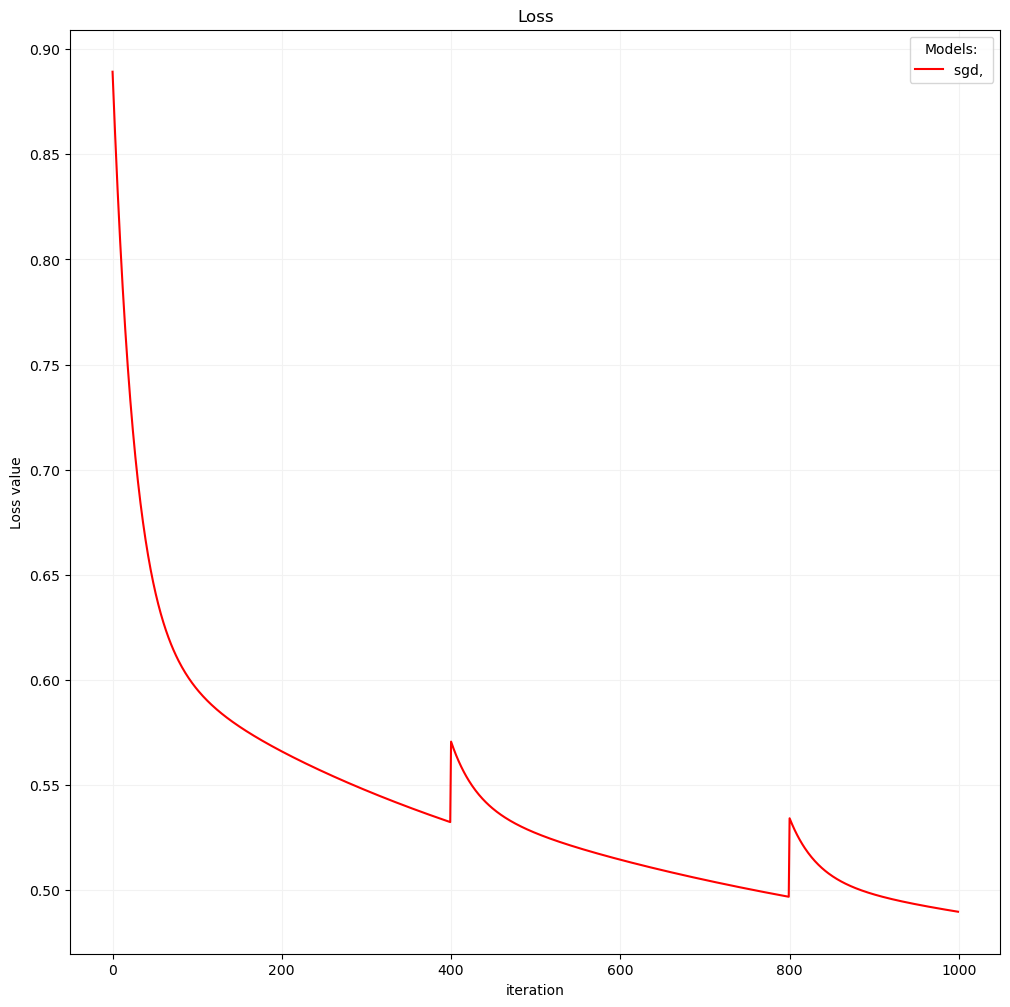

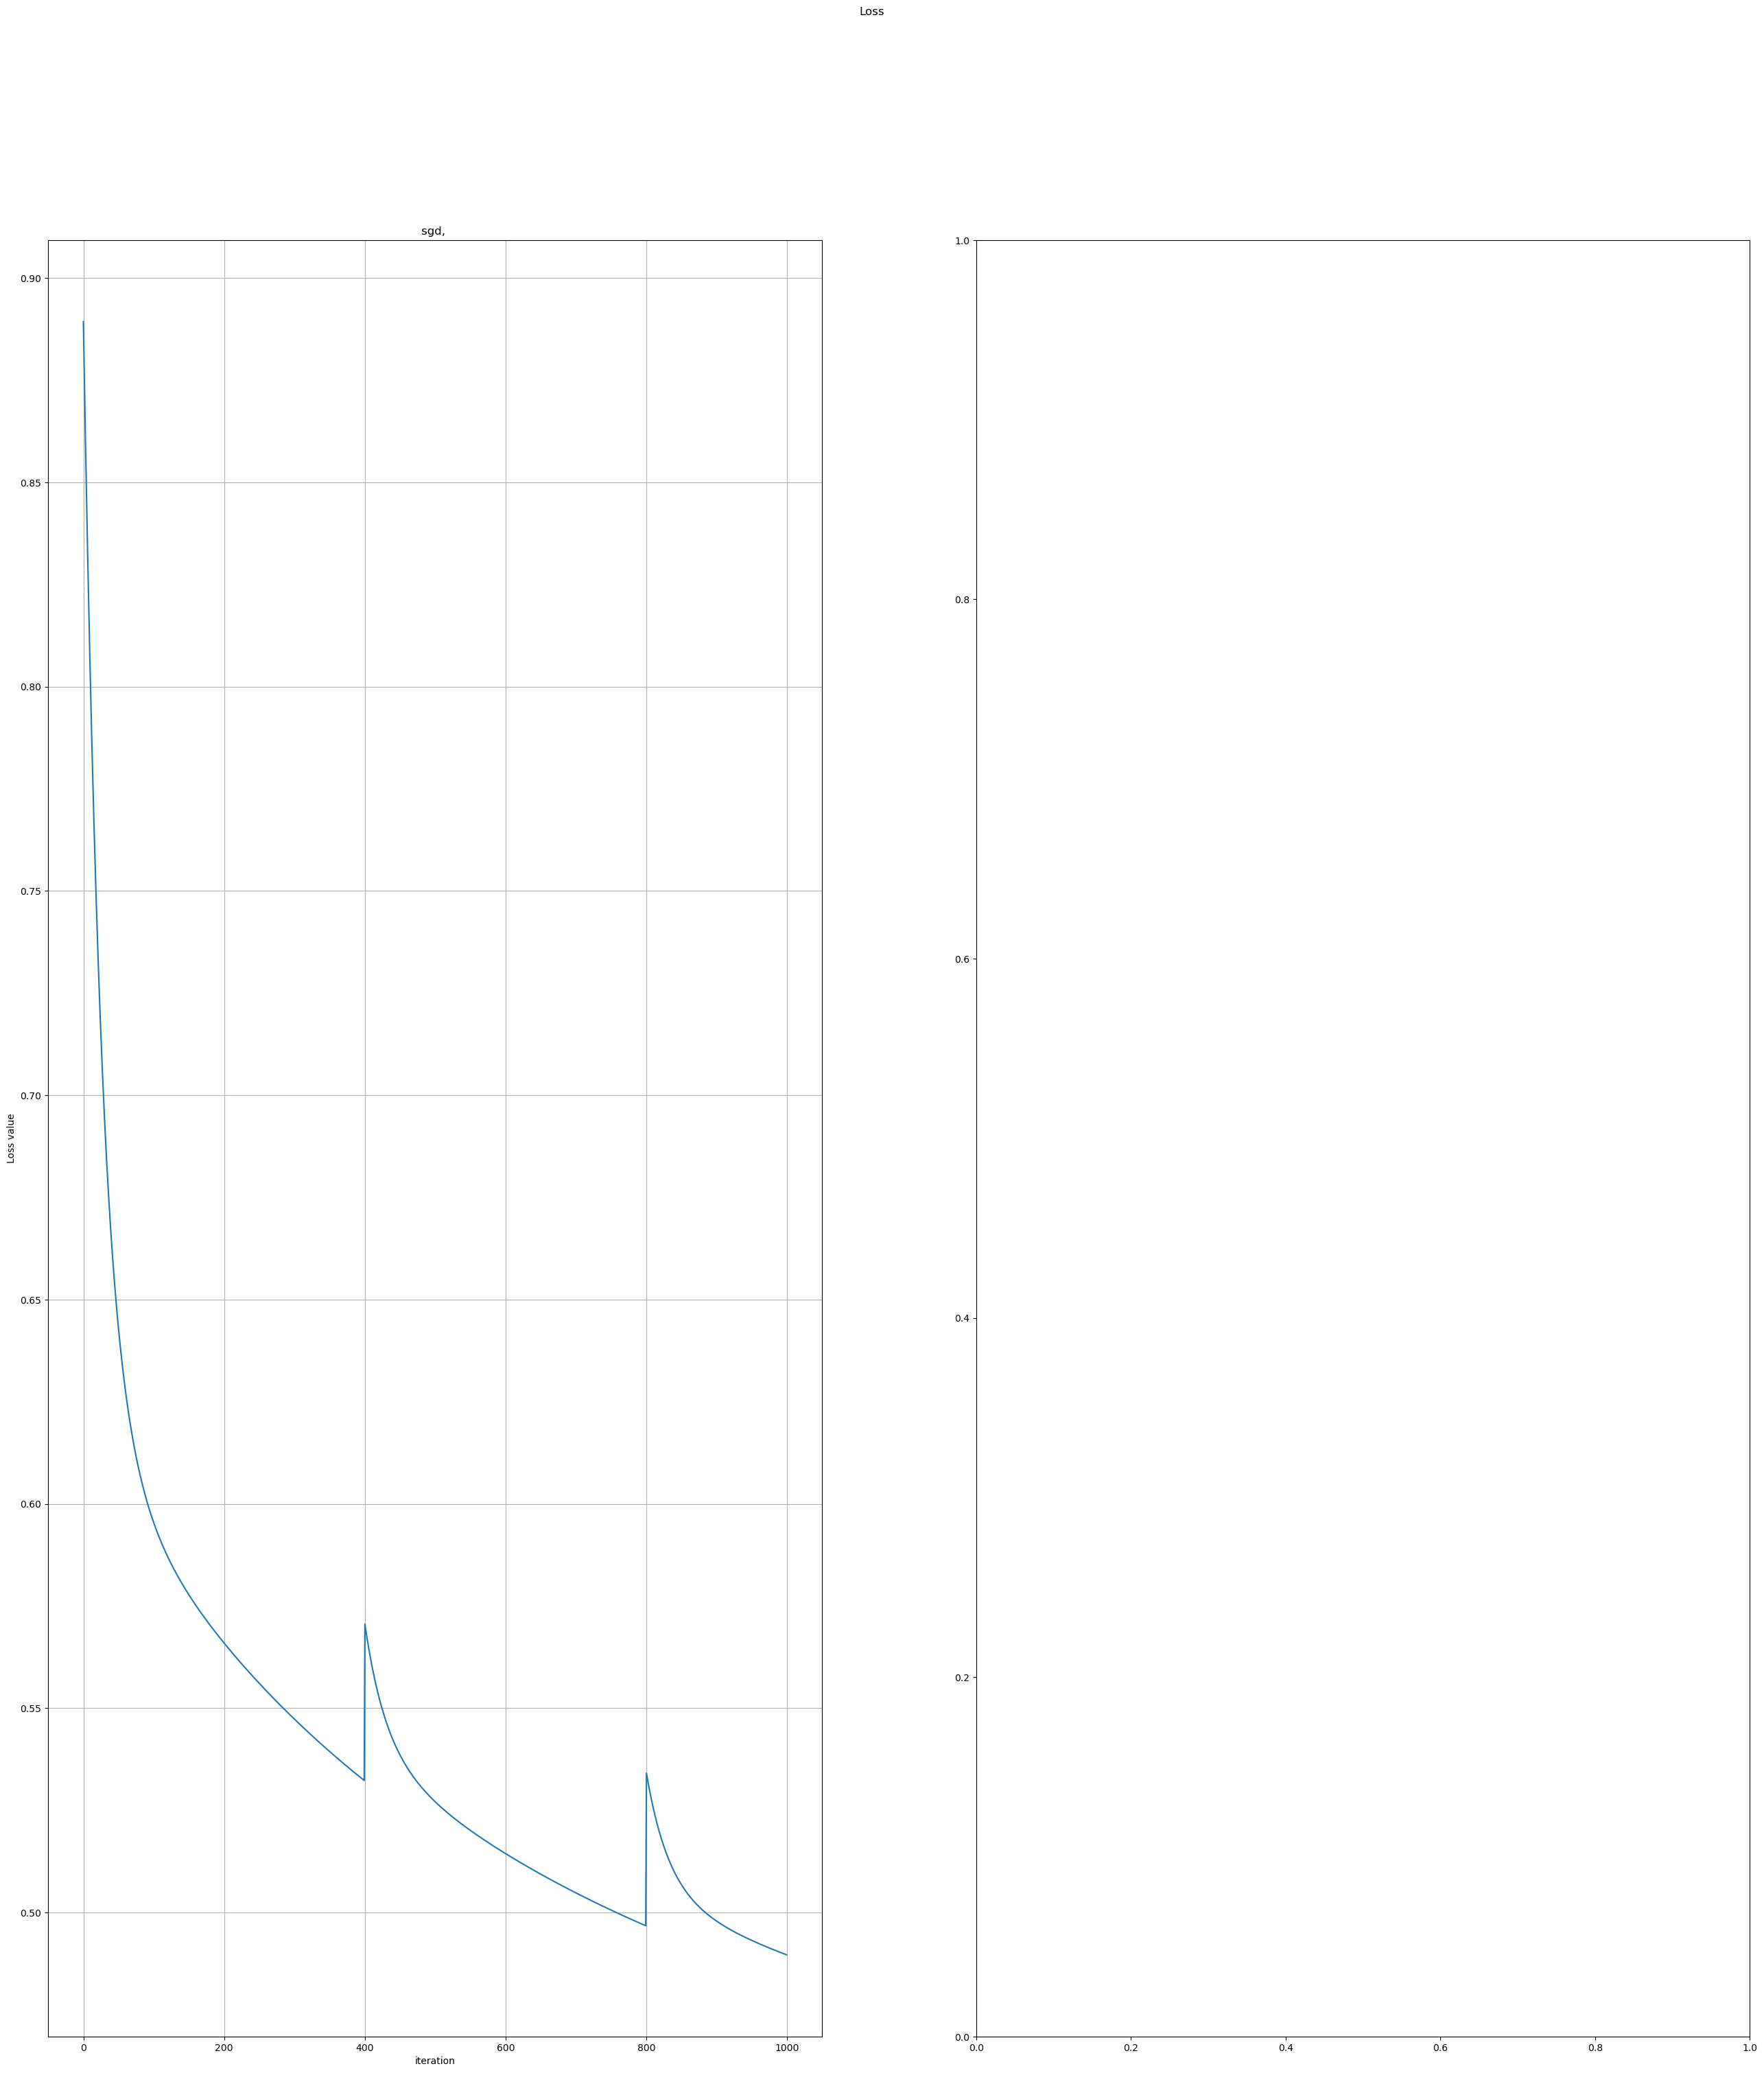

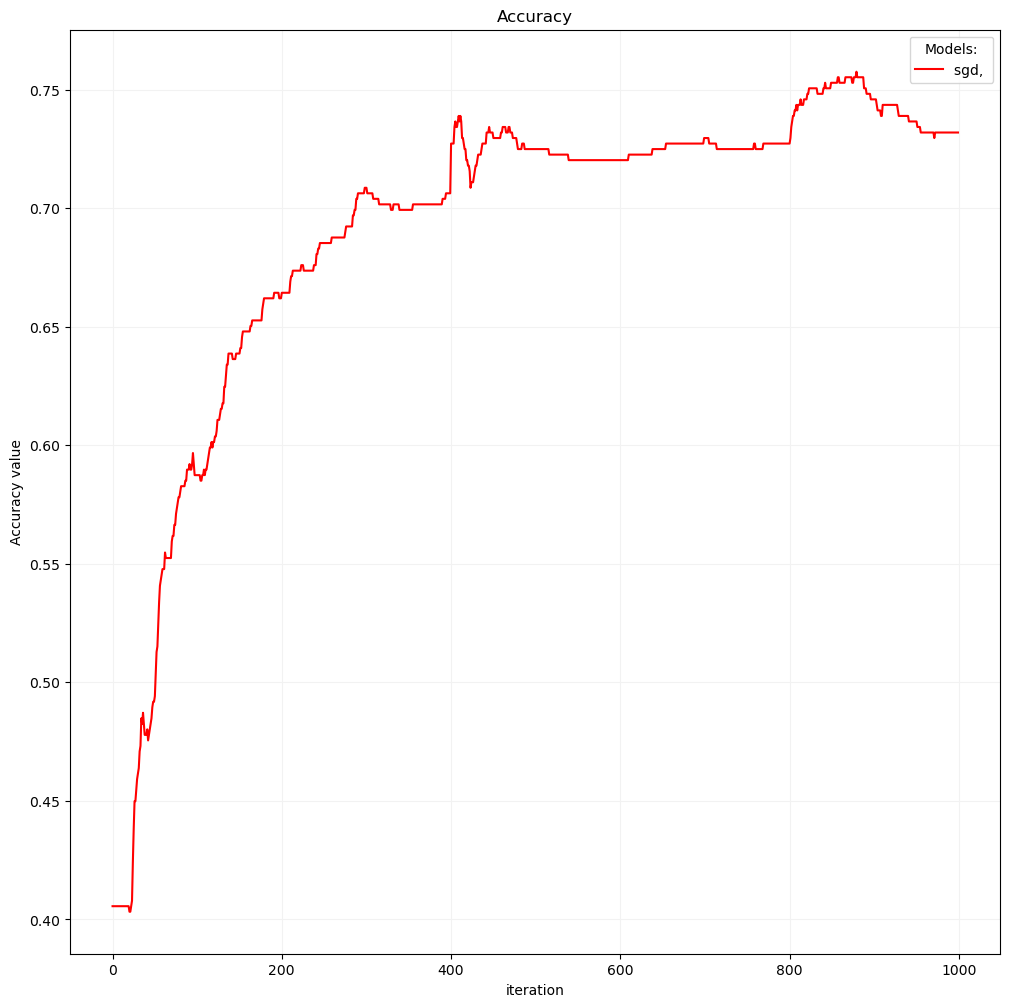

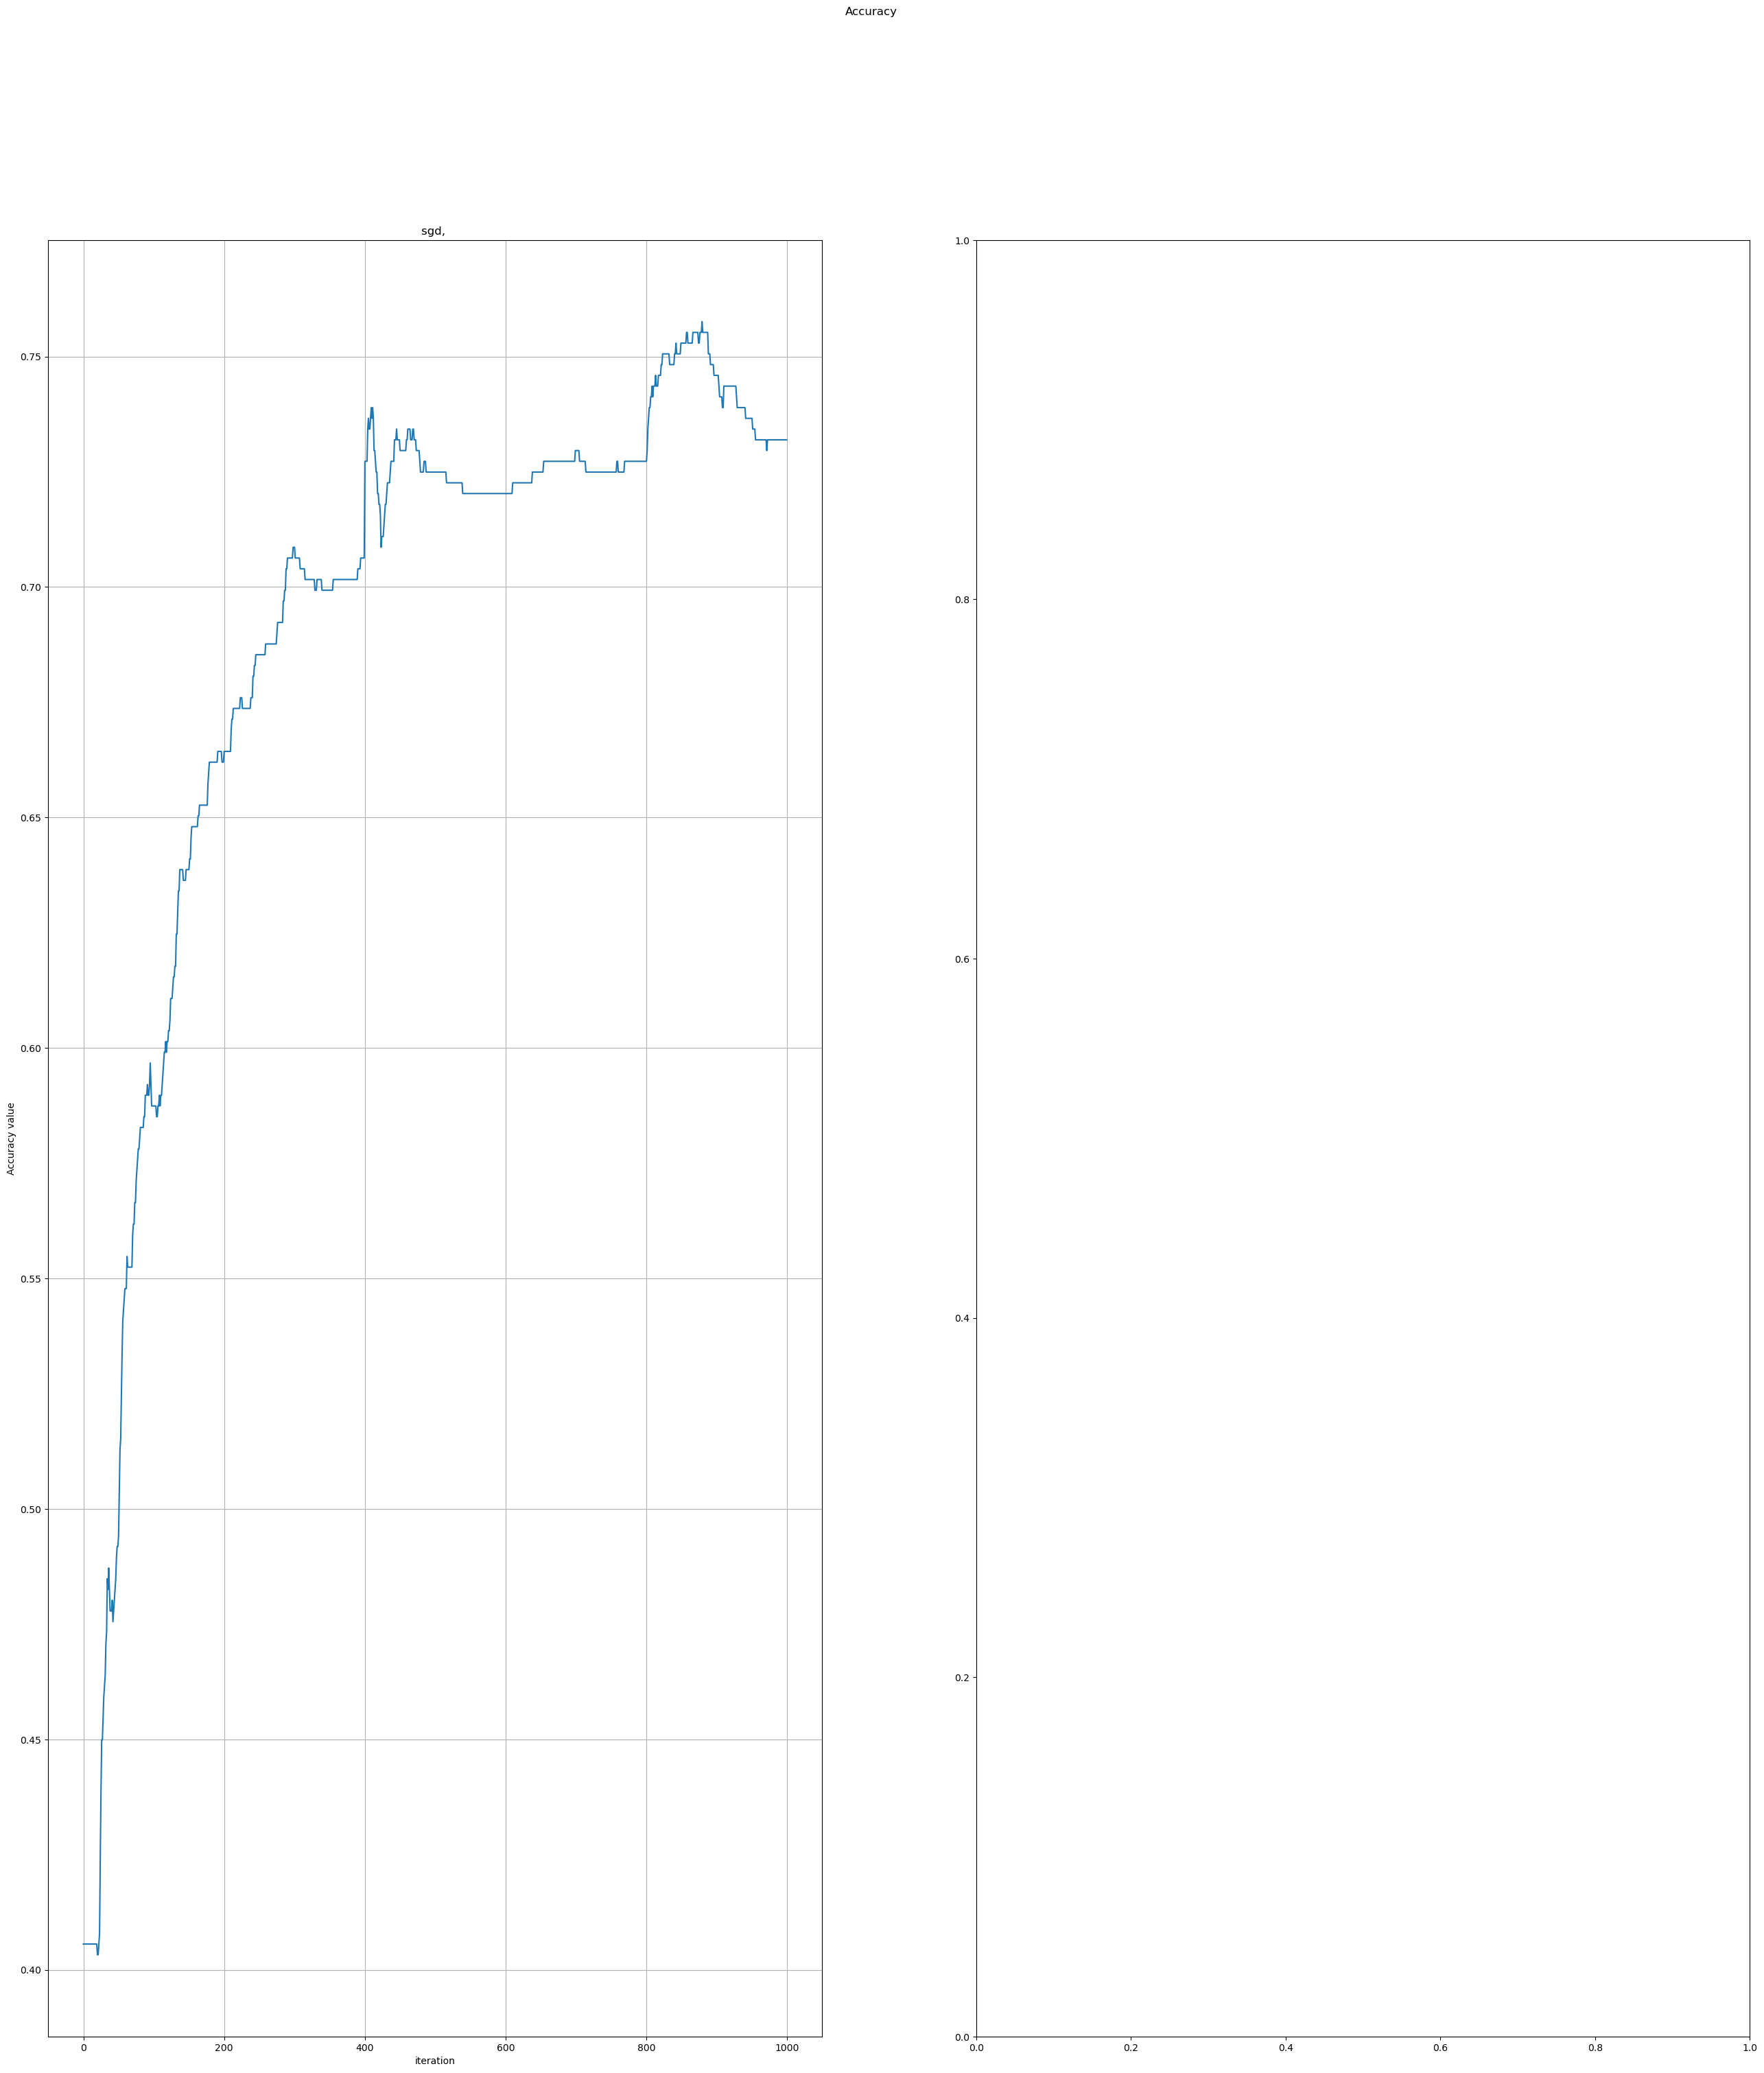

In [21]:
show_data_stat(stat_collector_array = r1,
               n_array = [1,2],
               gamma_array = [" "],
               line_type_array_loss = loss_array,
               line_type_array_acc = acc_array,
               color_array_l = loss_color_array,
               color_array_a = acc_color_array)

### Federated, preconditioner: Adam

In [22]:
#SGD
def adam_uniform_run(gamma):
    model_params = {"lr":LR_EPOCH['lr']}

    precond = [Adam_preconditioner(beta2 = gamma),
               Adam_preconditioner(beta2 = gamma),
               Adam_preconditioner(beta2 = gamma)]

    federated_ua_stat_collectors = [Statistic(X_test,y_test,"worker1_uniform_adam"),
                                    Statistic(X_test,y_test,"worker2_uniform_adam"),
                                    Statistic(X_test,y_test,"worker3_uniform_adam")]

    models = [Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                           lr = model_params['lr'], preconditioner = precond[0],
                                           epoch = 1,stat_collector=federated_ua_stat_collectors[0]),
              Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                           lr = model_params['lr'], preconditioner = precond[1],
                                           epoch = 1,stat_collector=federated_ua_stat_collectors[1]),
              Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                           lr = model_params['lr'], preconditioner = precond[2],
                                           epoch = 1,stat_collector=federated_ua_stat_collectors[2])]

    schedulers = [MatrixScheduler_Uniform(alpha=0.01,gamma=1.3,
                                          change_mode=MatrixScheduler_Uniform.change_on_each_iteration),
                  MatrixScheduler_Uniform(alpha=0.01,gamma=1.3,
                                          change_mode=MatrixScheduler_Uniform.change_on_each_iteration),
                  MatrixScheduler_Uniform(alpha=0.01,gamma=1.3,
                                          change_mode=MatrixScheduler_Uniform.change_on_each_iteration)]

    s = server(M_workers=3,
               X_train = X_train,y_train = y_train,
               stat_collectors = federated_ua_stat_collectors,
               models = models,
               data_splitter = "het",m_scheduler = schedulers)

    s.run(n_iter=LR_EPOCH['epoch'],T=400)
    
    return federated_ua_stat_collectors

In [23]:
r2 = tune(run_model = adam_uniform_run,
     m_type = "adam",
     model_name = "adam, ")

100%|█████████████████████████████████████████████| 3/3 [02:31<00:00, 50.36s/it]


#### сравнение: same method, different: n, $\gamma$

In [24]:
#['-','--','-.',':']
loss_array = ['-', '--', '-.',
              '-', '--', '-.',
             '-',  '--', '-.']
loss_color_array = ['r','k','b']#,
#                    'k','k','k',
#                    '#49FF00','#49FF00','#49FF00']
acc_array = ['-',  '--', ':',
             '-',  '--', ':',
             '-',  '--', ':']
acc_color_array = ['r','k','b']#,
#                    'k','k','k',
#                    '#49FF00','#49FF00','#49FF00']

#acc_array = []
#acc_color_array = ['#FF8054','#FF0000','#BC220F',
#                    '#00FFDC','#0093FF','#0000FF',
#                    '#00FF00','#32B400','#006432']

adam, betta2: 0.4
balanced_accuracy_score: 0.7629817444219067
accuracy_score: 0.7692307692307692
adam, betta2: 0.6
balanced_accuracy_score: 0.7601081812035159
accuracy_score: 0.7668997668997669
adam, betta2: 0.8
balanced_accuracy_score: 0.7629817444219067
accuracy_score: 0.7692307692307693


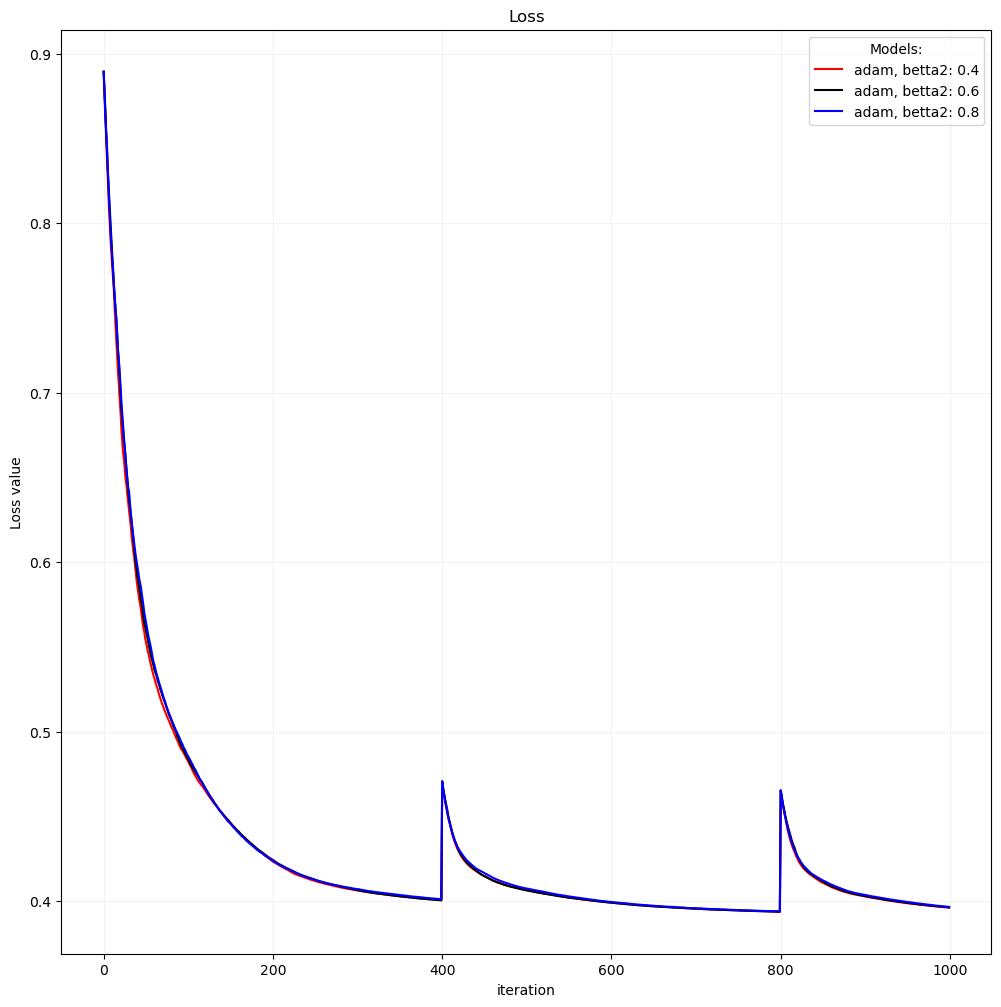

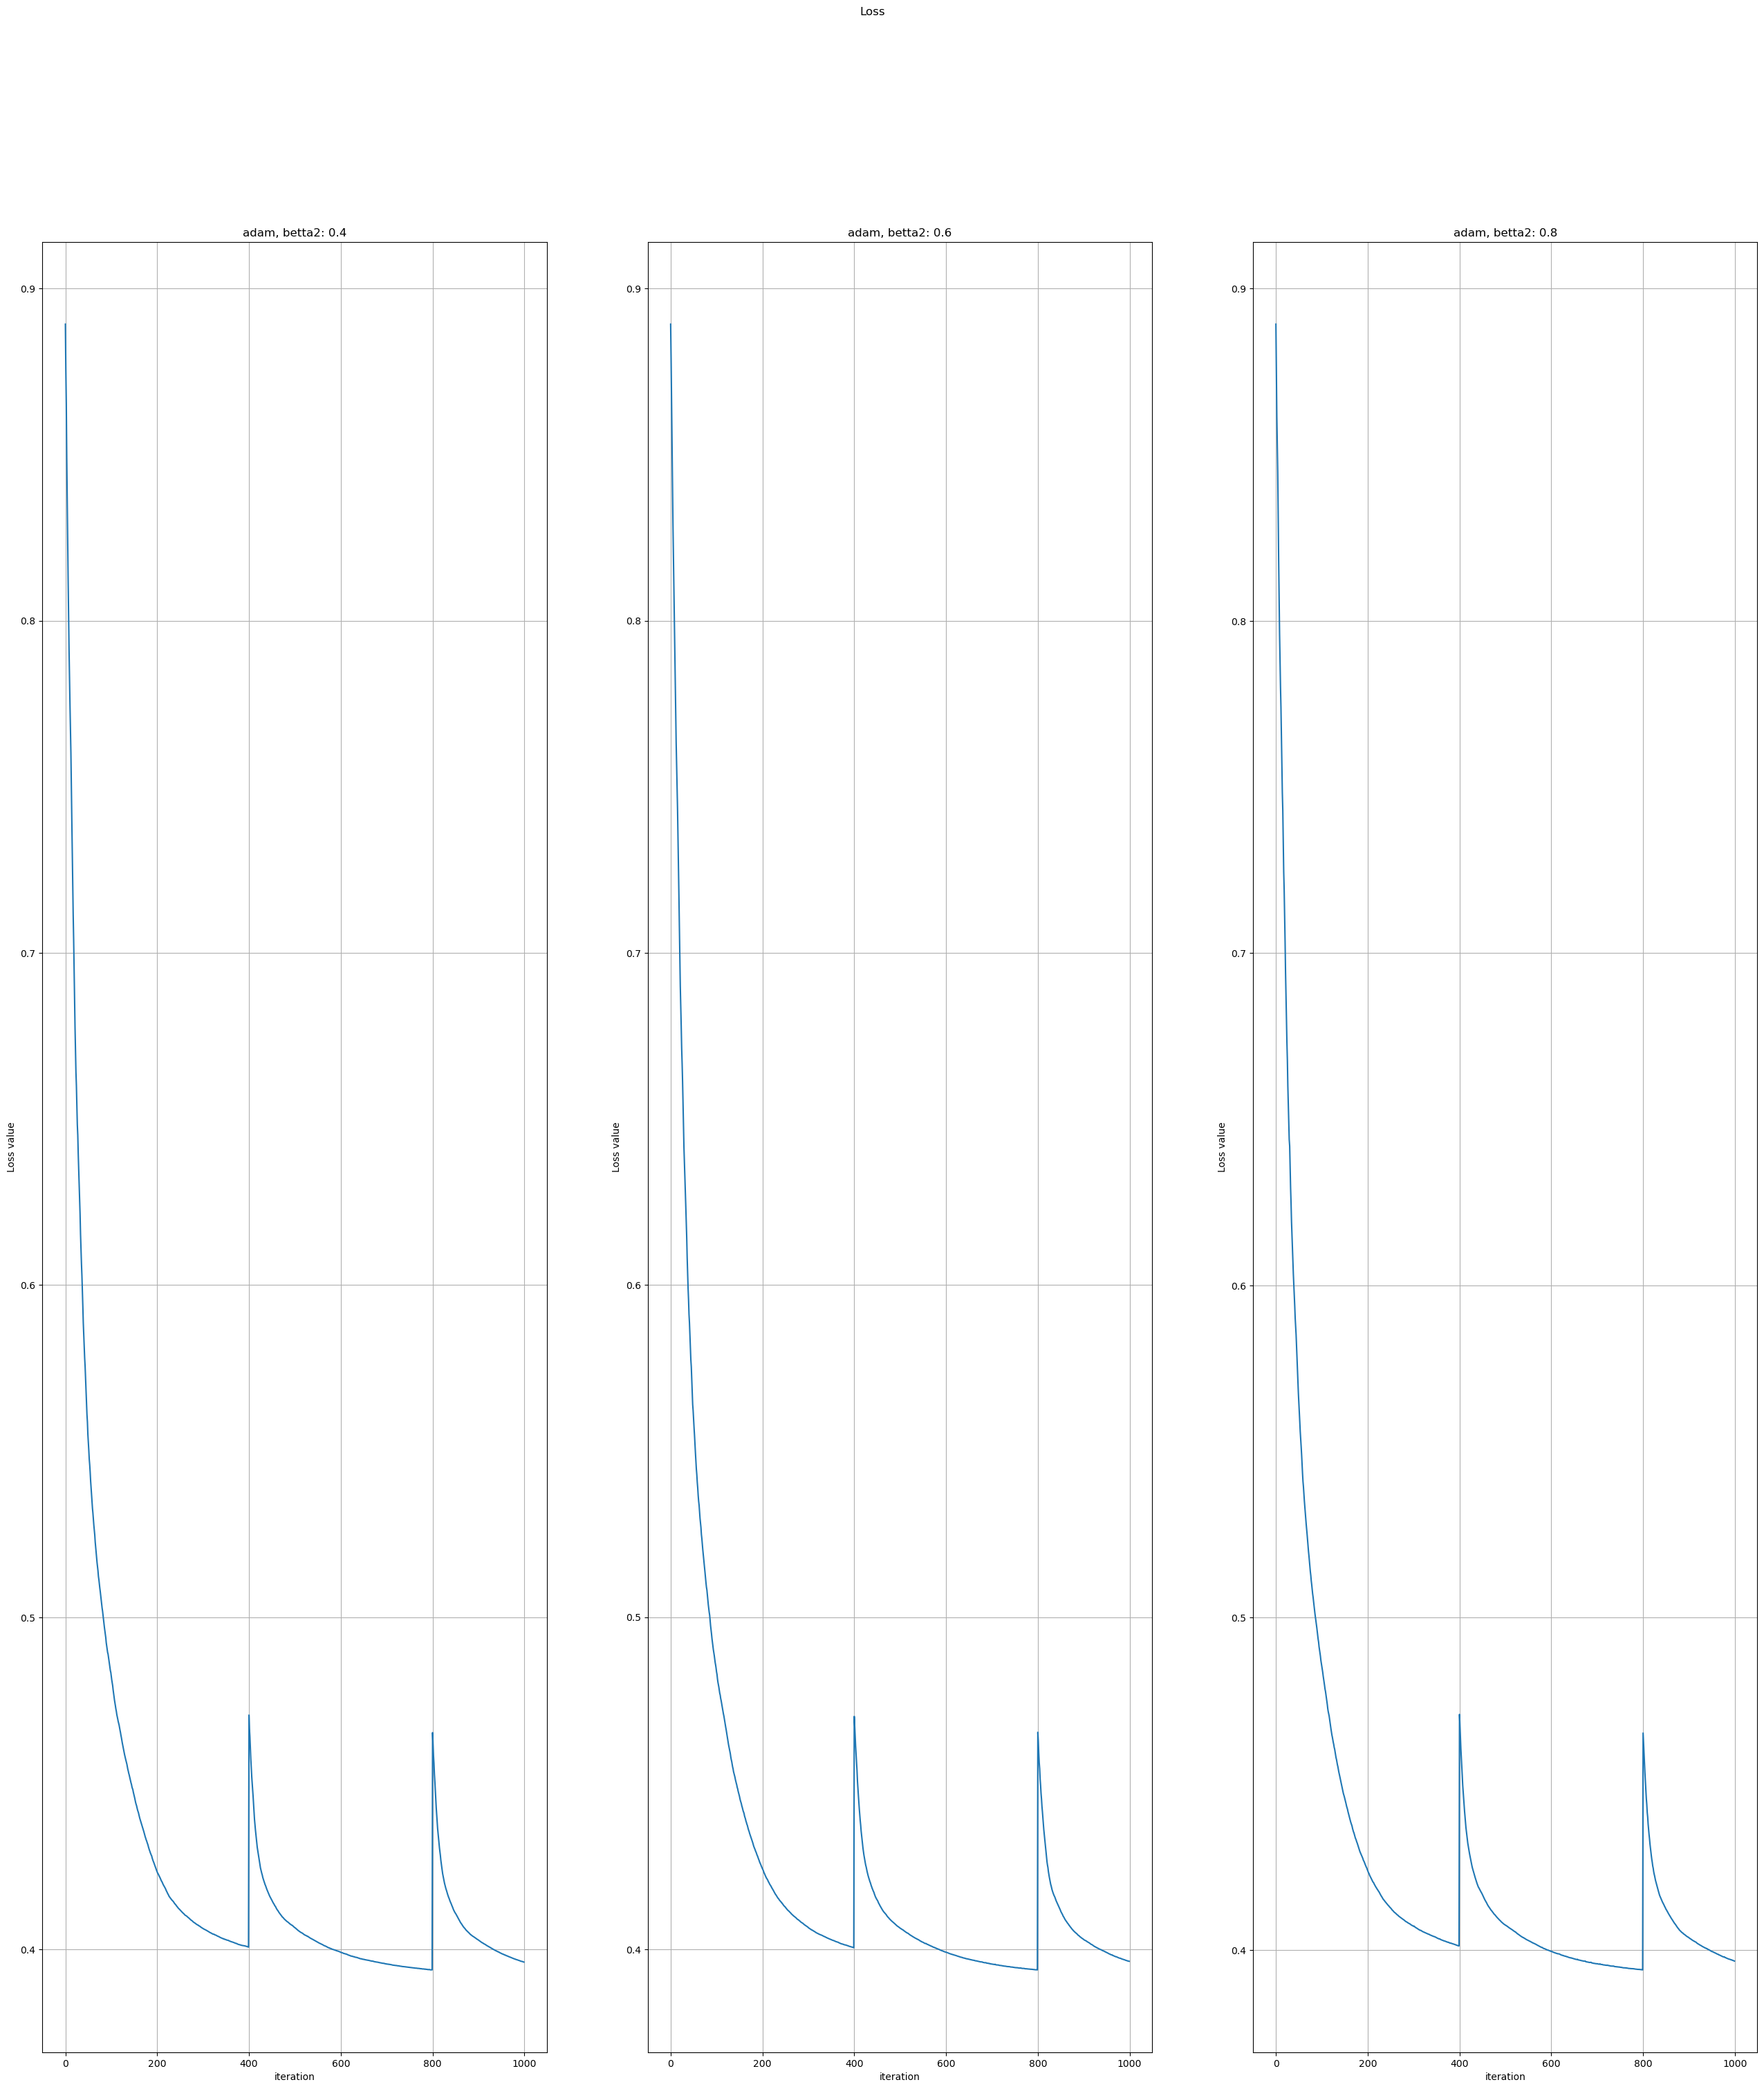

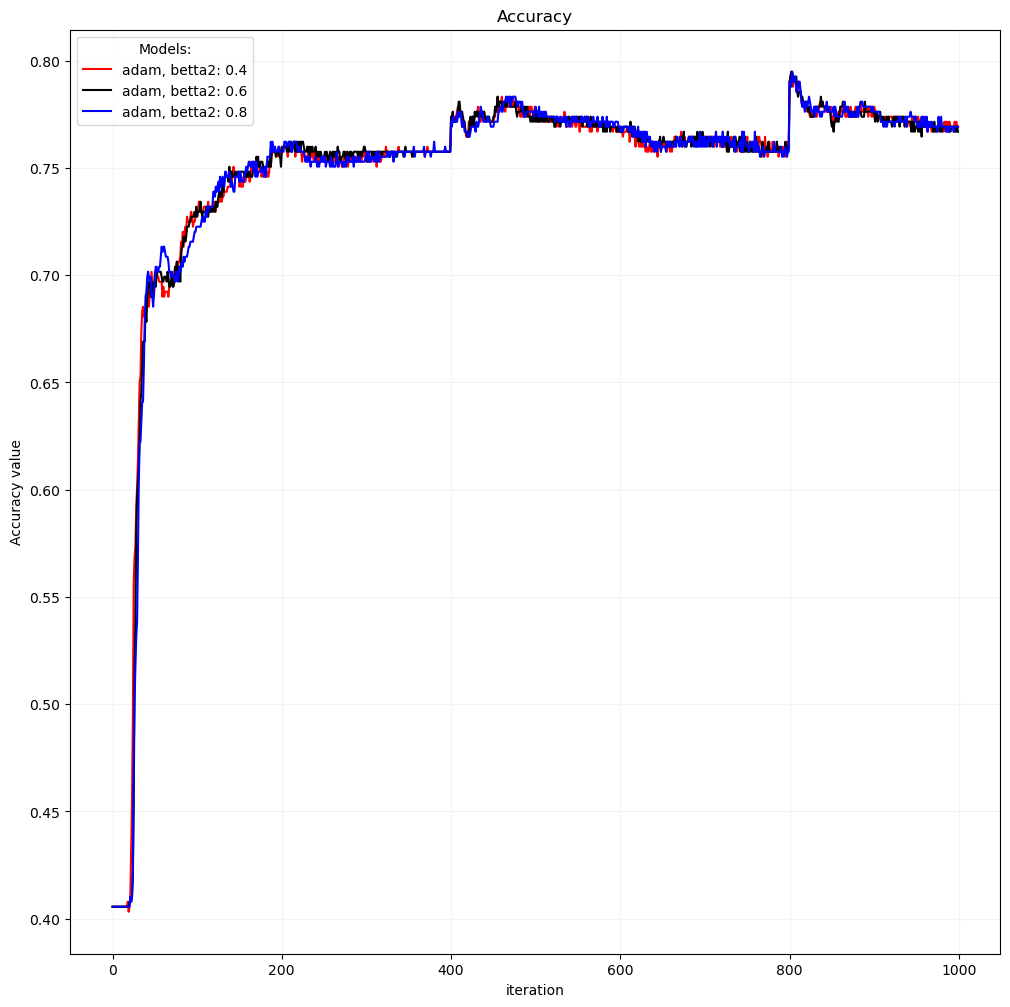

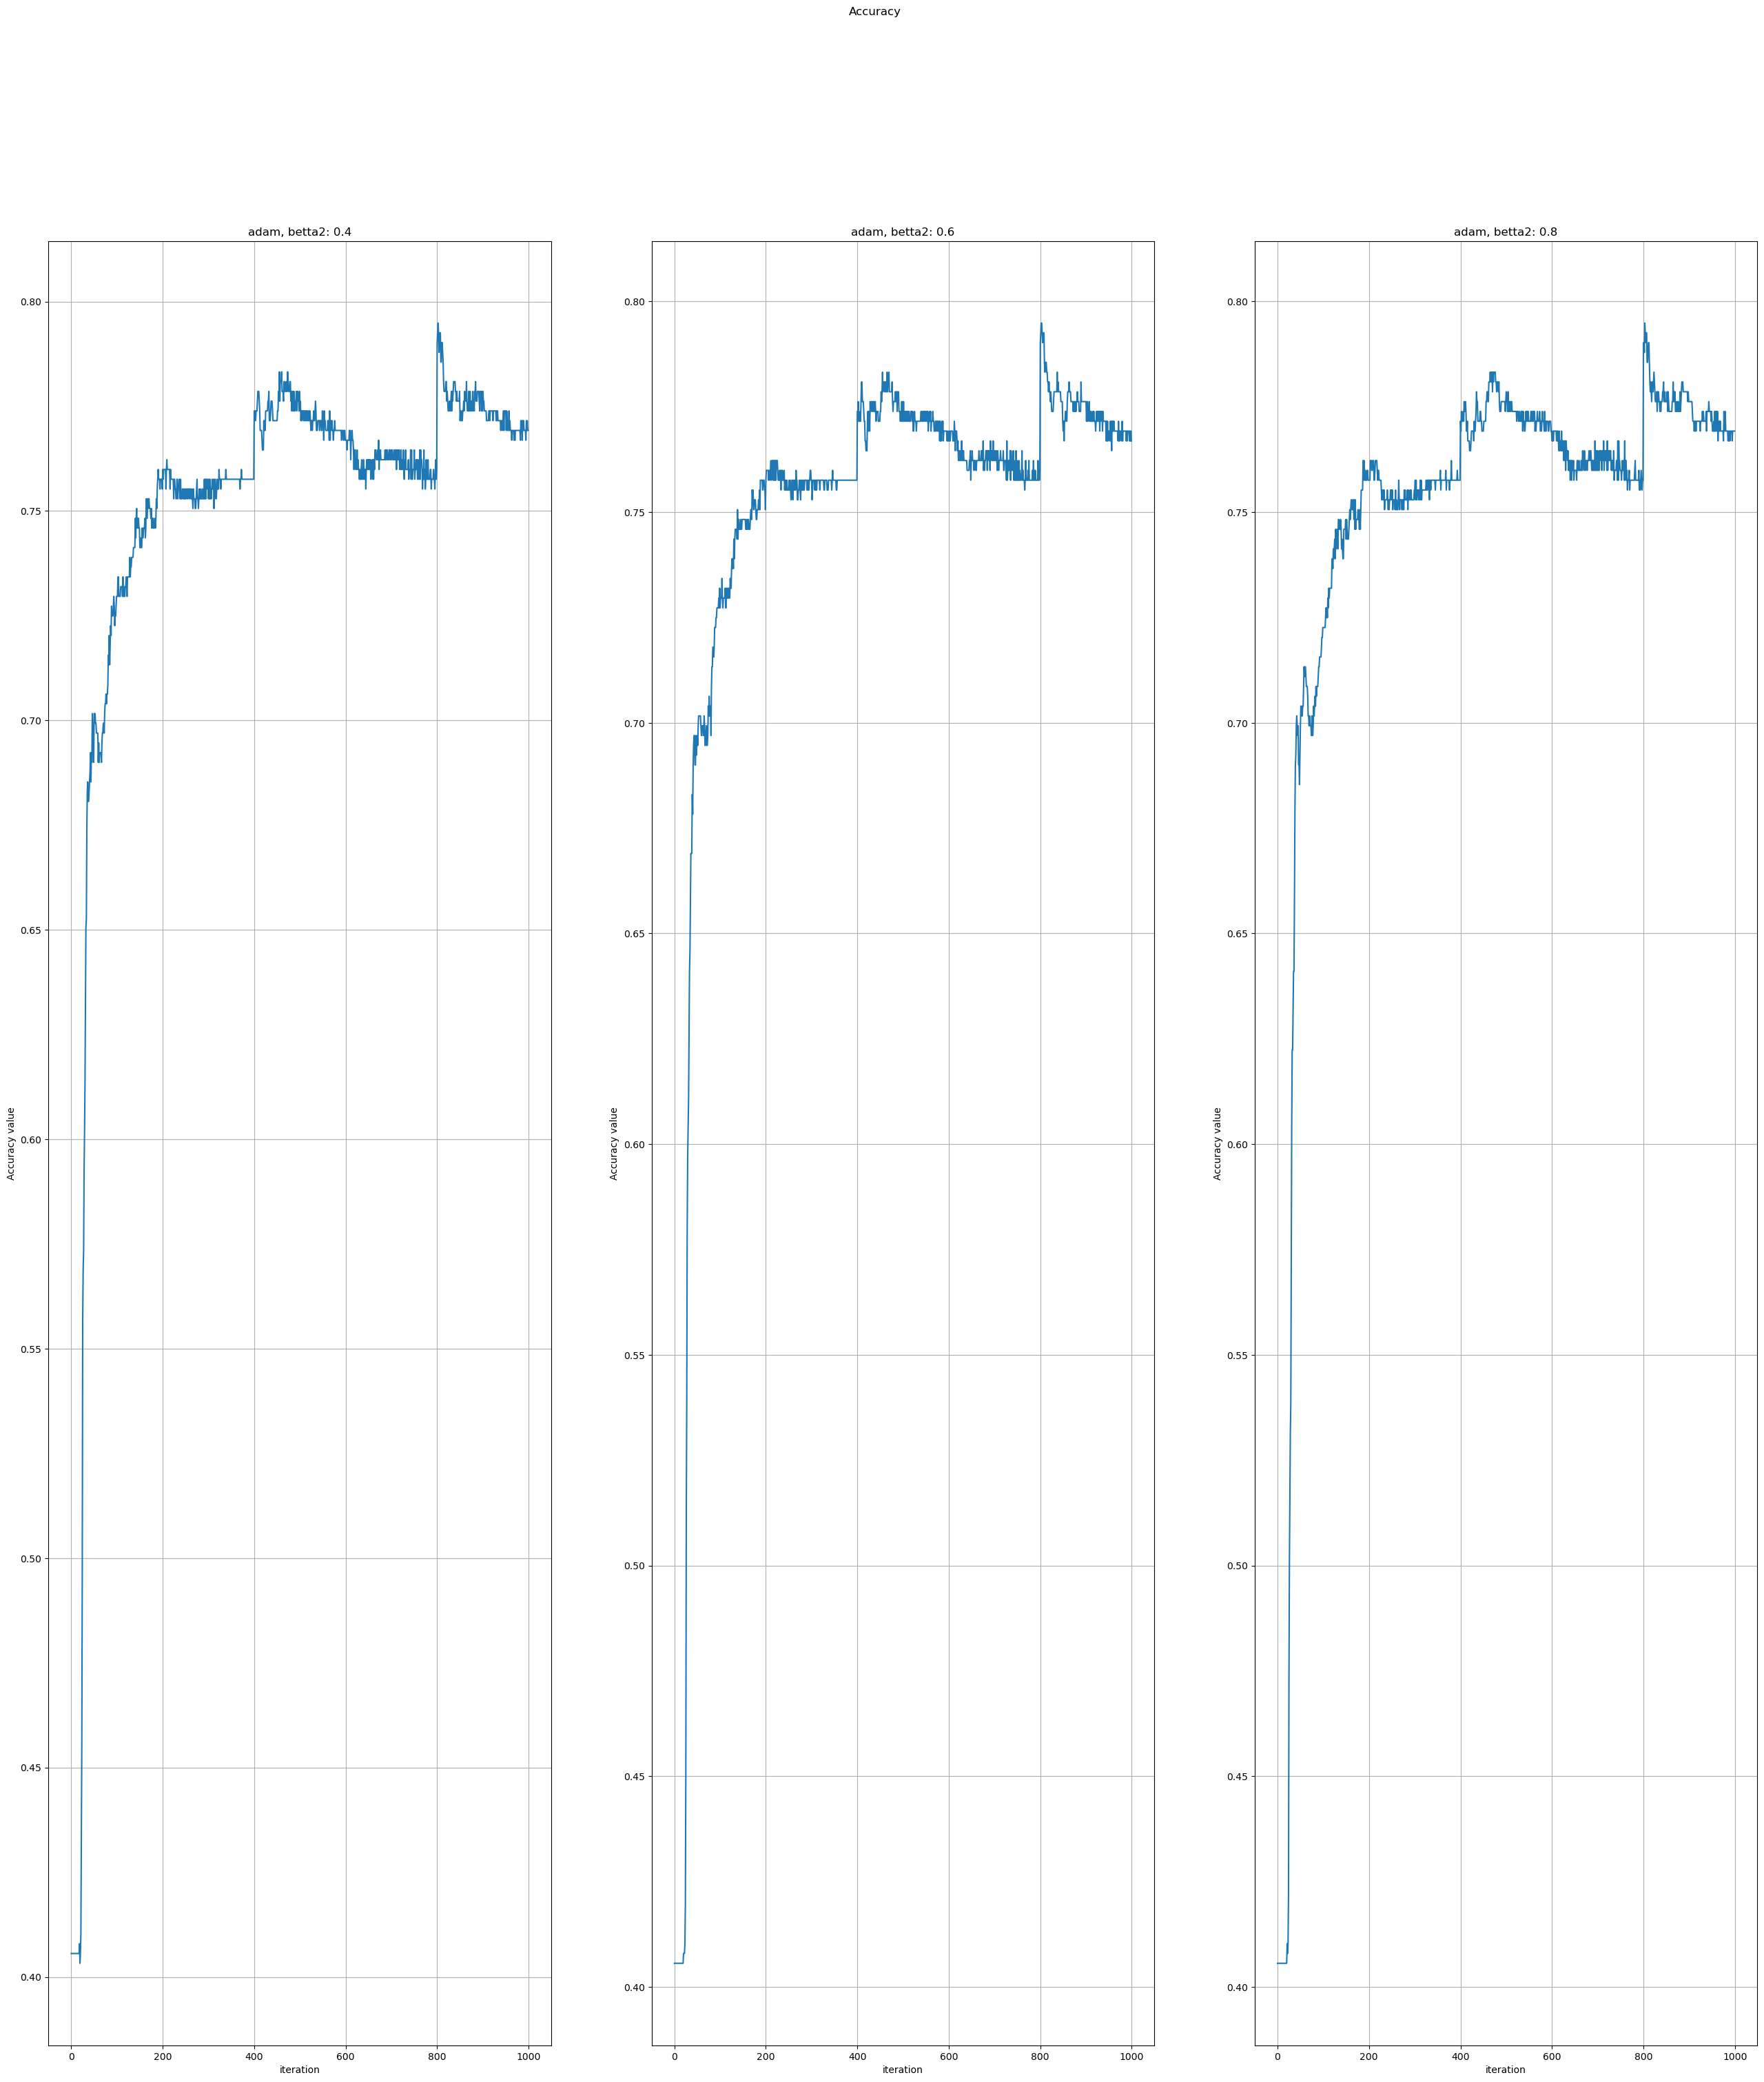

In [25]:
show_data_stat(stat_collector_array = r2,
               n_array = beta2,
               gamma_array = [" "],
               line_type_array_loss = loss_array,
               line_type_array_acc = acc_array,
               color_array_l = loss_color_array,
               color_array_a = acc_color_array)

### Federated, preconditioner: OASIS

In [26]:
#OASIS
def oasis_uniform_run(gamma,n):
    model_params = {"lr":LR_EPOCH['lr']}

    precond = [OASIS_preconditioner(beta2 = gamma,alpha=n),
               OASIS_preconditioner(beta2 = gamma,alpha=n),
               OASIS_preconditioner(beta2 = gamma,alpha=n)]

    federated_uo_stat_collectors = [Statistic(X_test,y_test,"worker1_uniform_oasis"),
                                    Statistic(X_test,y_test,"worker2_uniform_oasis"),
                                    Statistic(X_test,y_test,"worker3_uniform_oasis")]

    models = [Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                           lr = model_params['lr'], preconditioner = precond[0],
                                           epoch = 1,stat_collector=federated_uo_stat_collectors[0]),
              Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                           lr = model_params['lr'], preconditioner = precond[1],
                                           epoch = 1,stat_collector=federated_uo_stat_collectors[1]),
              Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                           lr = model_params['lr'], preconditioner = precond[2],
                                           epoch = 1,stat_collector=federated_uo_stat_collectors[2])]

    schedulers = [MatrixScheduler_Uniform(alpha=0.01,gamma=1.3,
                                          change_mode=MatrixScheduler_Uniform.change_on_each_iteration),
                  MatrixScheduler_Uniform(alpha=0.01,gamma=1.3,
                                          change_mode=MatrixScheduler_Uniform.change_on_each_iteration),
                  MatrixScheduler_Uniform(alpha=0.01,gamma=1.3,
                                          change_mode=MatrixScheduler_Uniform.change_on_each_iteration)]

    s = server(M_workers=3,
               X_train = X_train,y_train = y_train,
               stat_collectors = federated_uo_stat_collectors,
               models = models,
               data_splitter = "het",m_scheduler = schedulers)

    s.run(n_iter=LR_EPOCH['epoch'],T=400)
    
    return federated_uo_stat_collectors

In [27]:
r3 = tune(run_model = oasis_uniform_run,
     m_type = "oasis",
     model_name = "oasis, ")

100%|█████████████████████████████████████████████| 6/6 [03:41<00:00, 36.88s/it]


#### сравнение: same method, different: n, $\gamma$

In [28]:
#['-','--','-.',':']
loss_array = ['-', '--', '-.',
              '-', '--', '-.']
loss_color_array = ['r','r','r',
                   'b','b','b']
#                    'k','k','k',
#                    '#49FF00','#49FF00','#49FF00']
acc_array = ['-',  '--', ':',
             '-',  '--', ':']
acc_color_array = ['r','r','r',
                  'b','b','b']#',
#                    'k','k','k',
#                    '#49FF00','#49FF00','#49FF00']

acc_array = []
#acc_color_array = ['#FF8054','#FF0000','#BC220F',
#                    '#00FFDC','#0093FF','#0000FF',
#                    '#00FF00','#32B400','#006432']

oasis, alpha:0.0001,betta:0.2
balanced_accuracy_score: 0.7457403651115619
accuracy_score: 0.7552447552447553
oasis, alpha:0.01,betta:0.2
balanced_accuracy_score: 0.7582826233941854
accuracy_score: 0.7668997668997669
oasis, alpha:6e-05,betta:0.2
balanced_accuracy_score: 0.7561866125760649
accuracy_score: 0.7622377622377622
oasis, alpha:0.0001,betta:0.6
balanced_accuracy_score: 0.7534482758620689
accuracy_score: 0.7622377622377622
oasis, alpha:0.01,betta:0.6
balanced_accuracy_score: 0.7650777552400271
accuracy_score: 0.7738927738927739
oasis, alpha:6e-05,betta:0.6
balanced_accuracy_score: 0.7563218390804597
accuracy_score: 0.7645687645687645


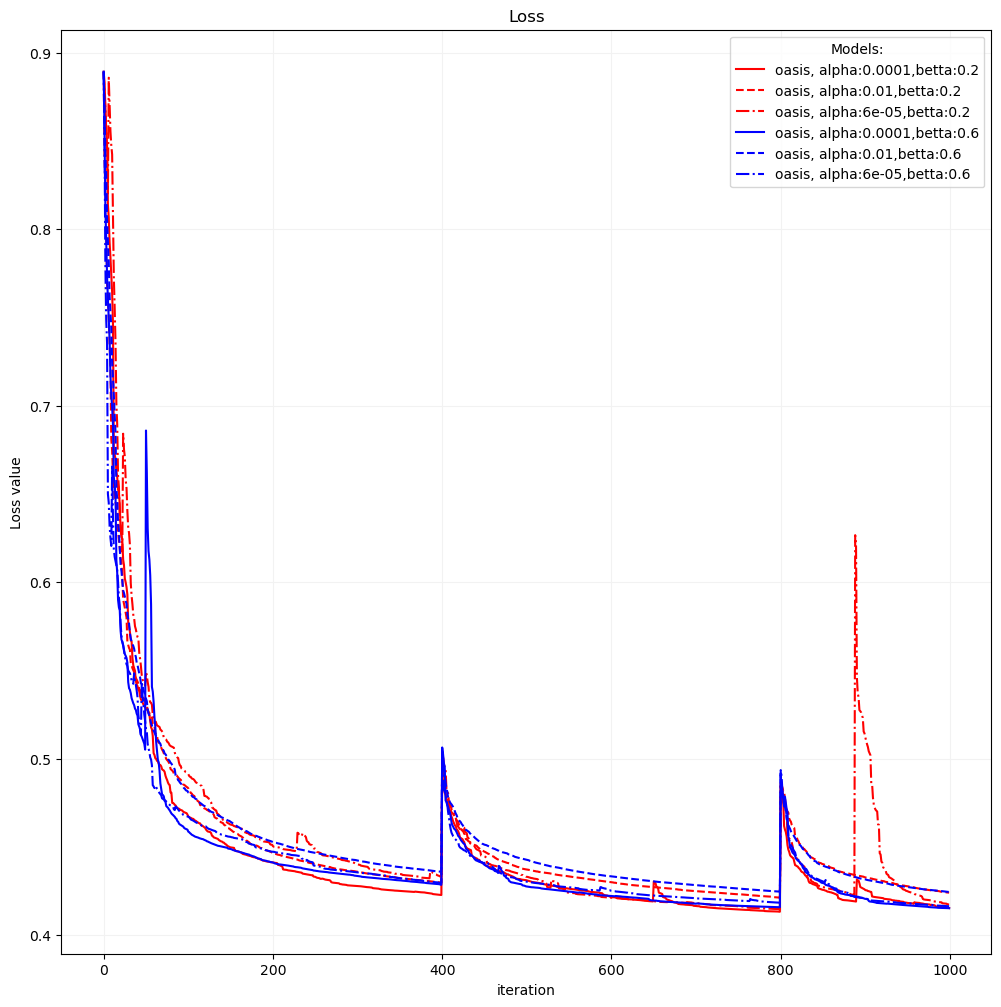

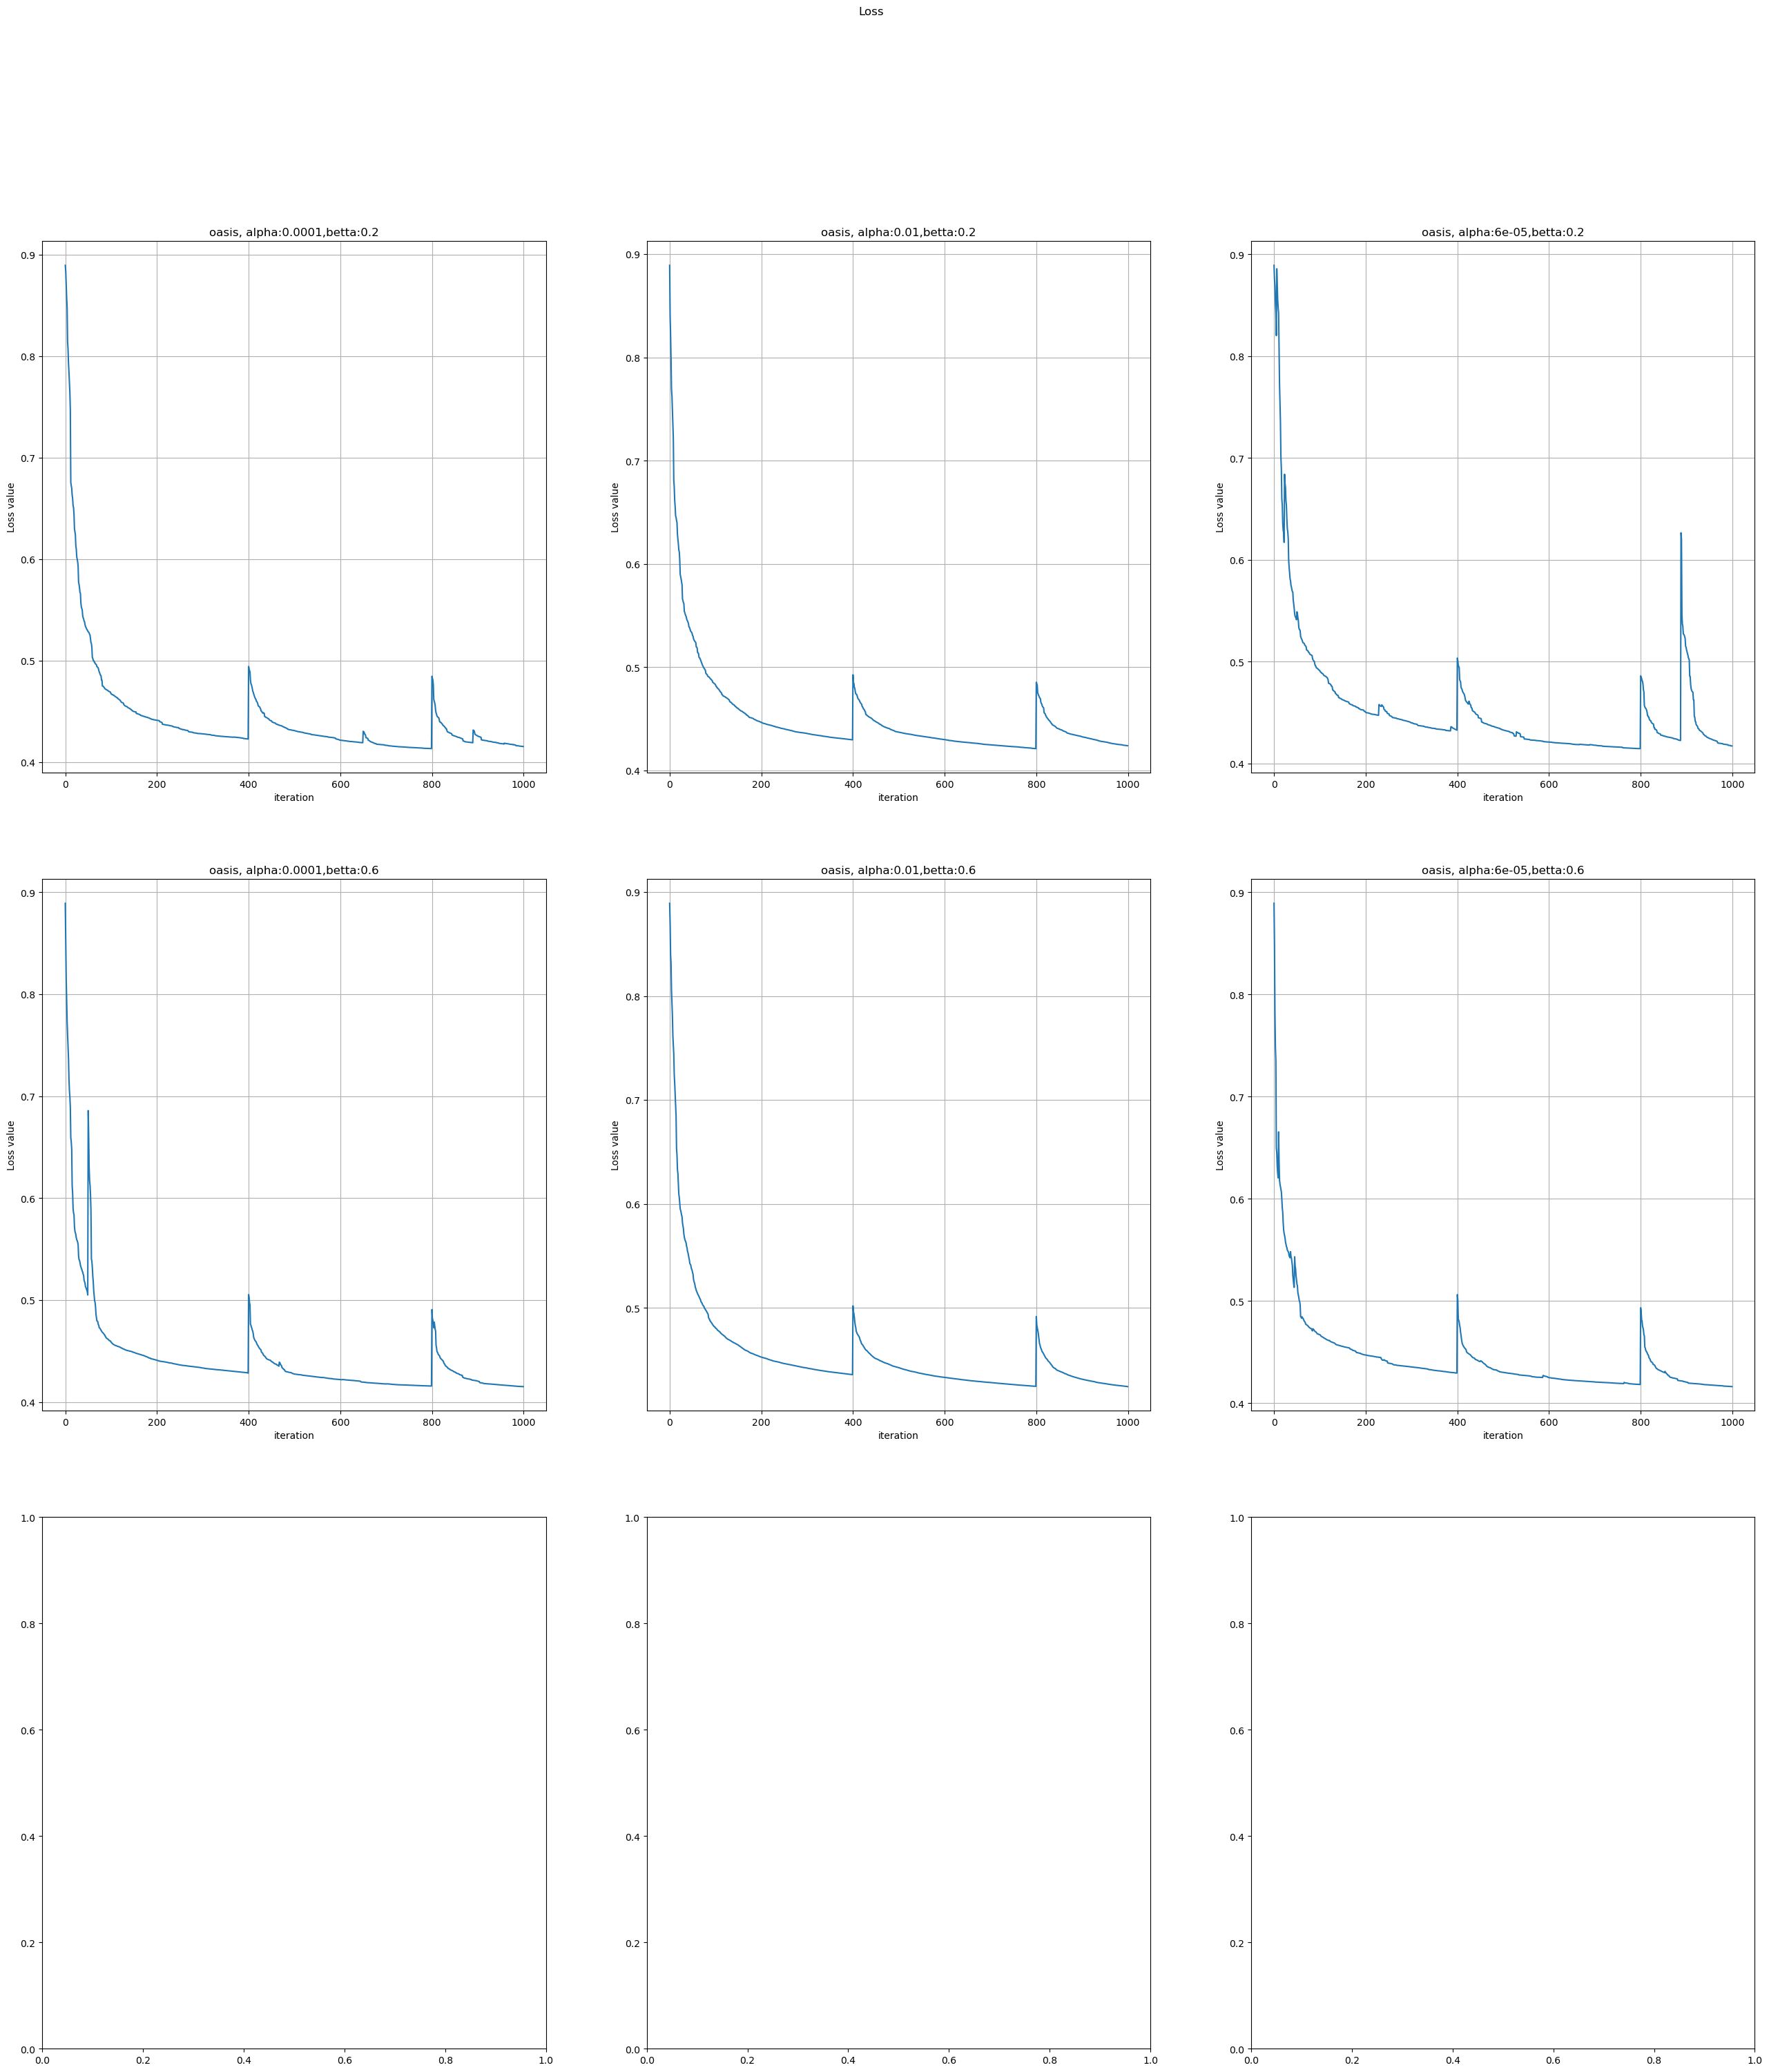

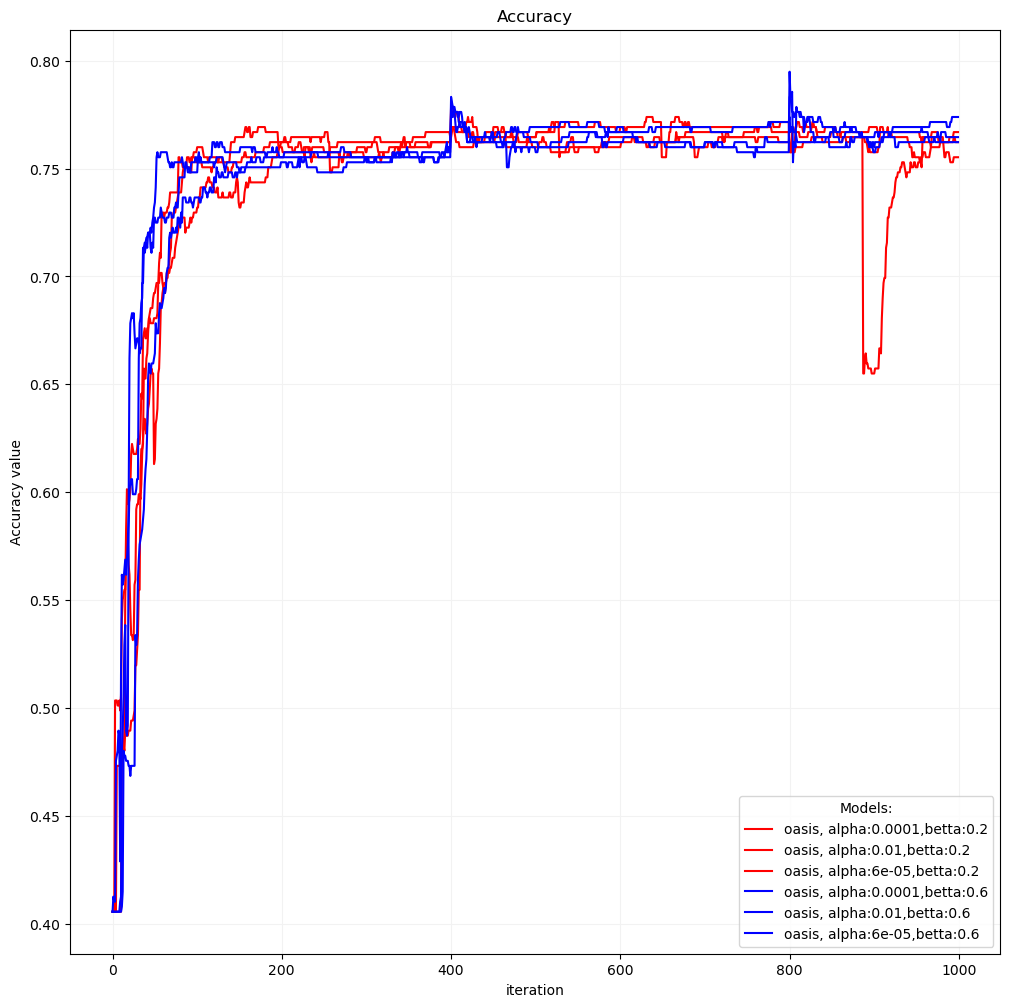

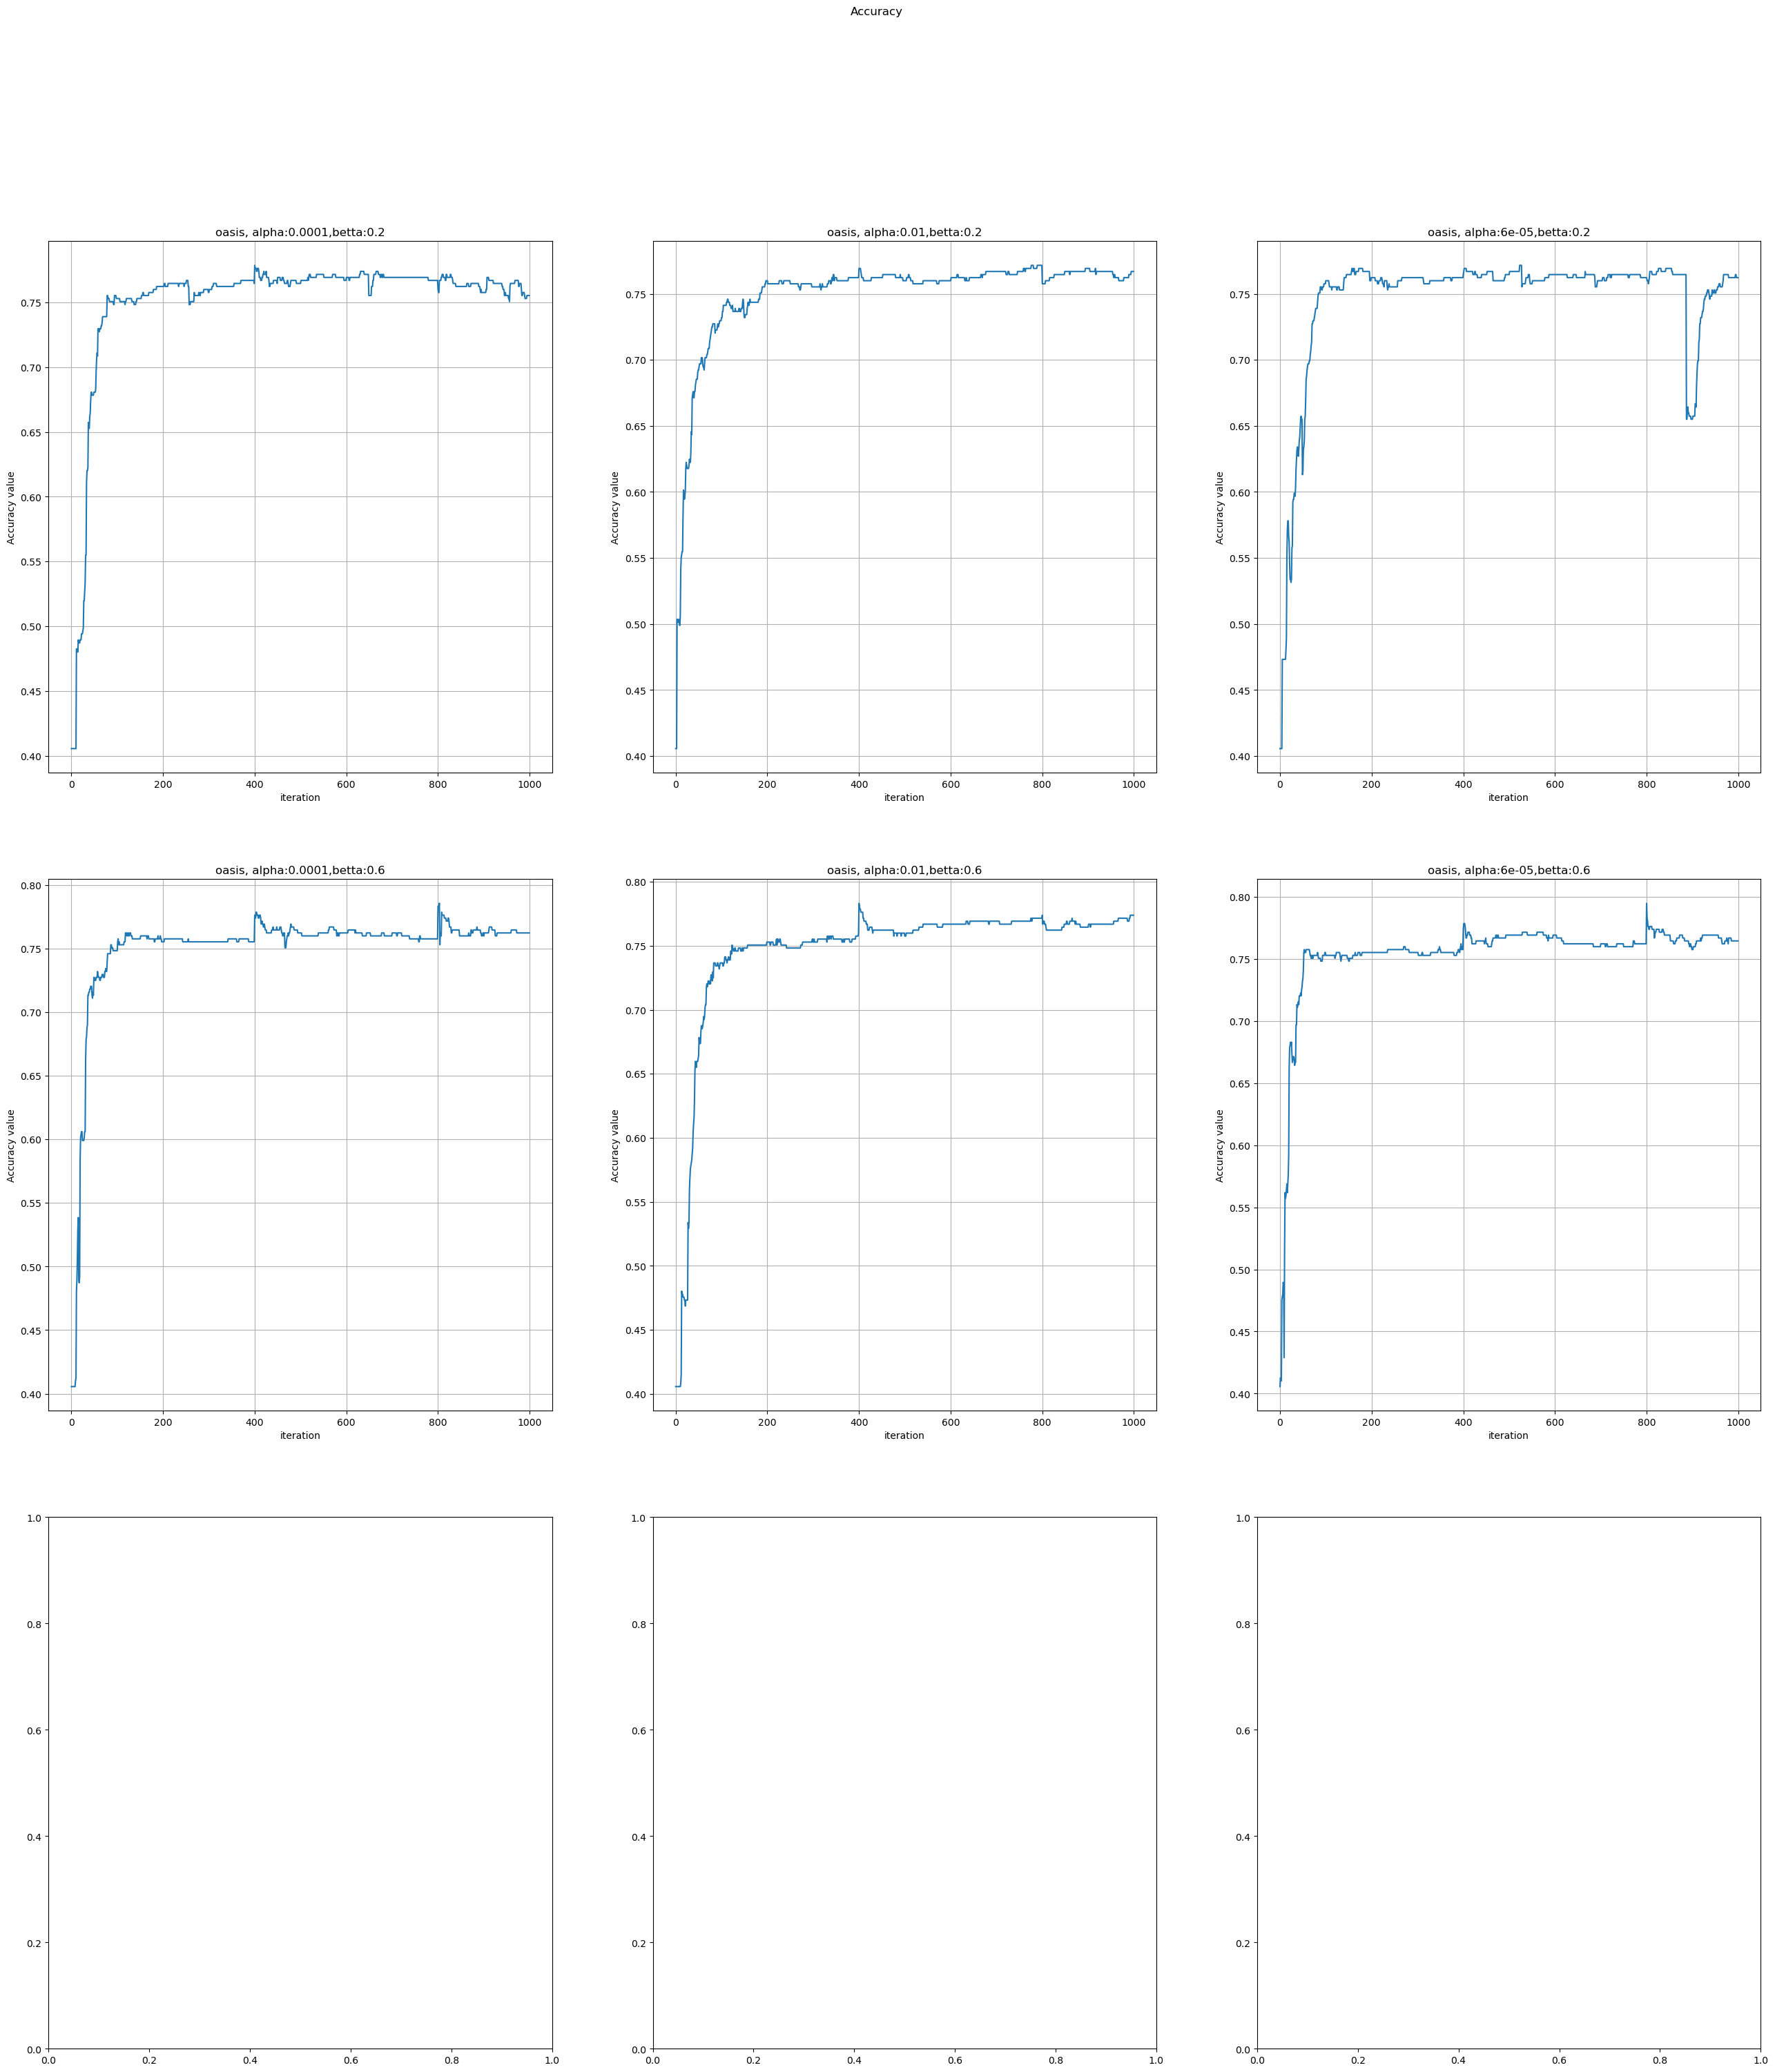

In [29]:
show_data_stat(stat_collector_array = r3,
               n_array = beta2,
               gamma_array = alpha,
               line_type_array_loss = loss_array,
               line_type_array_acc = acc_array,
               color_array_l = loss_color_array,
               color_array_a = acc_color_array)

### Сравнение 3 методов при одном n, $\gamma$

In [30]:
alpha,beta,beta2

([0.0001, 0.01, 6e-05], [0.2, 0.6], [0.4, 0.6, 0.8])

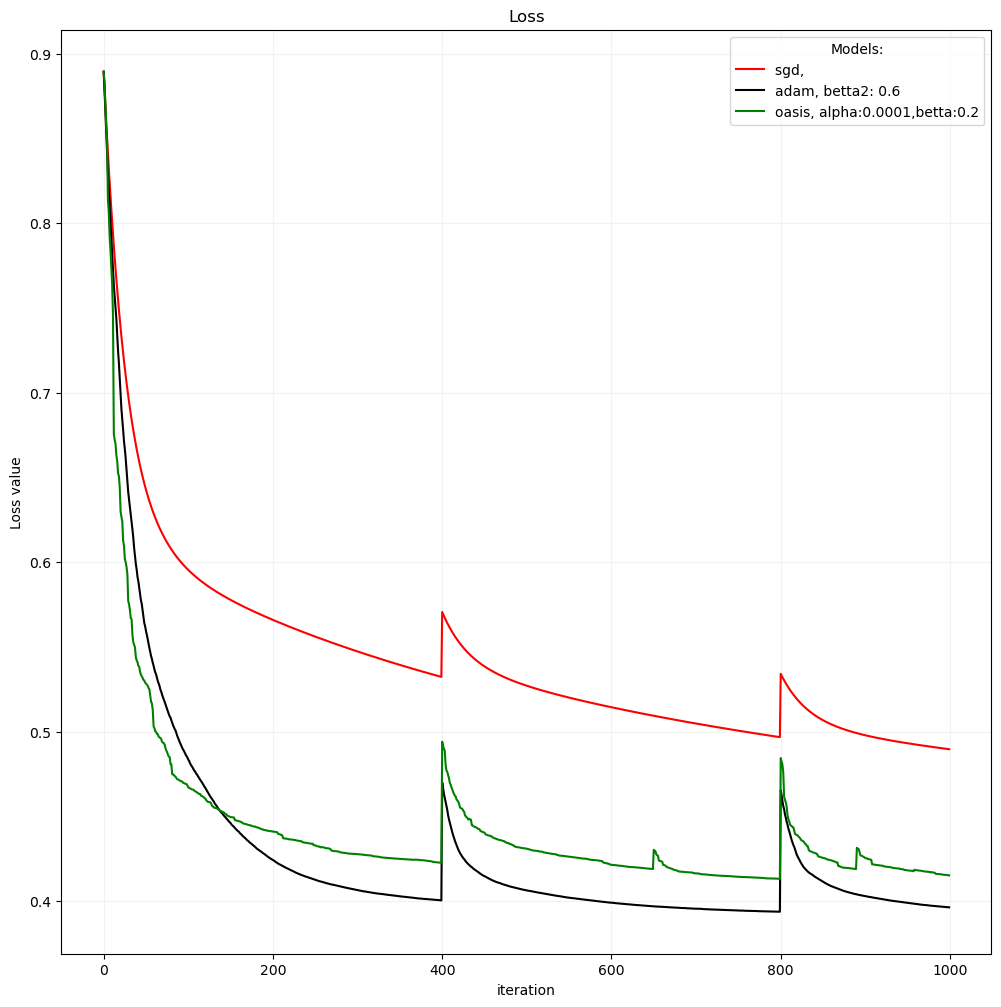

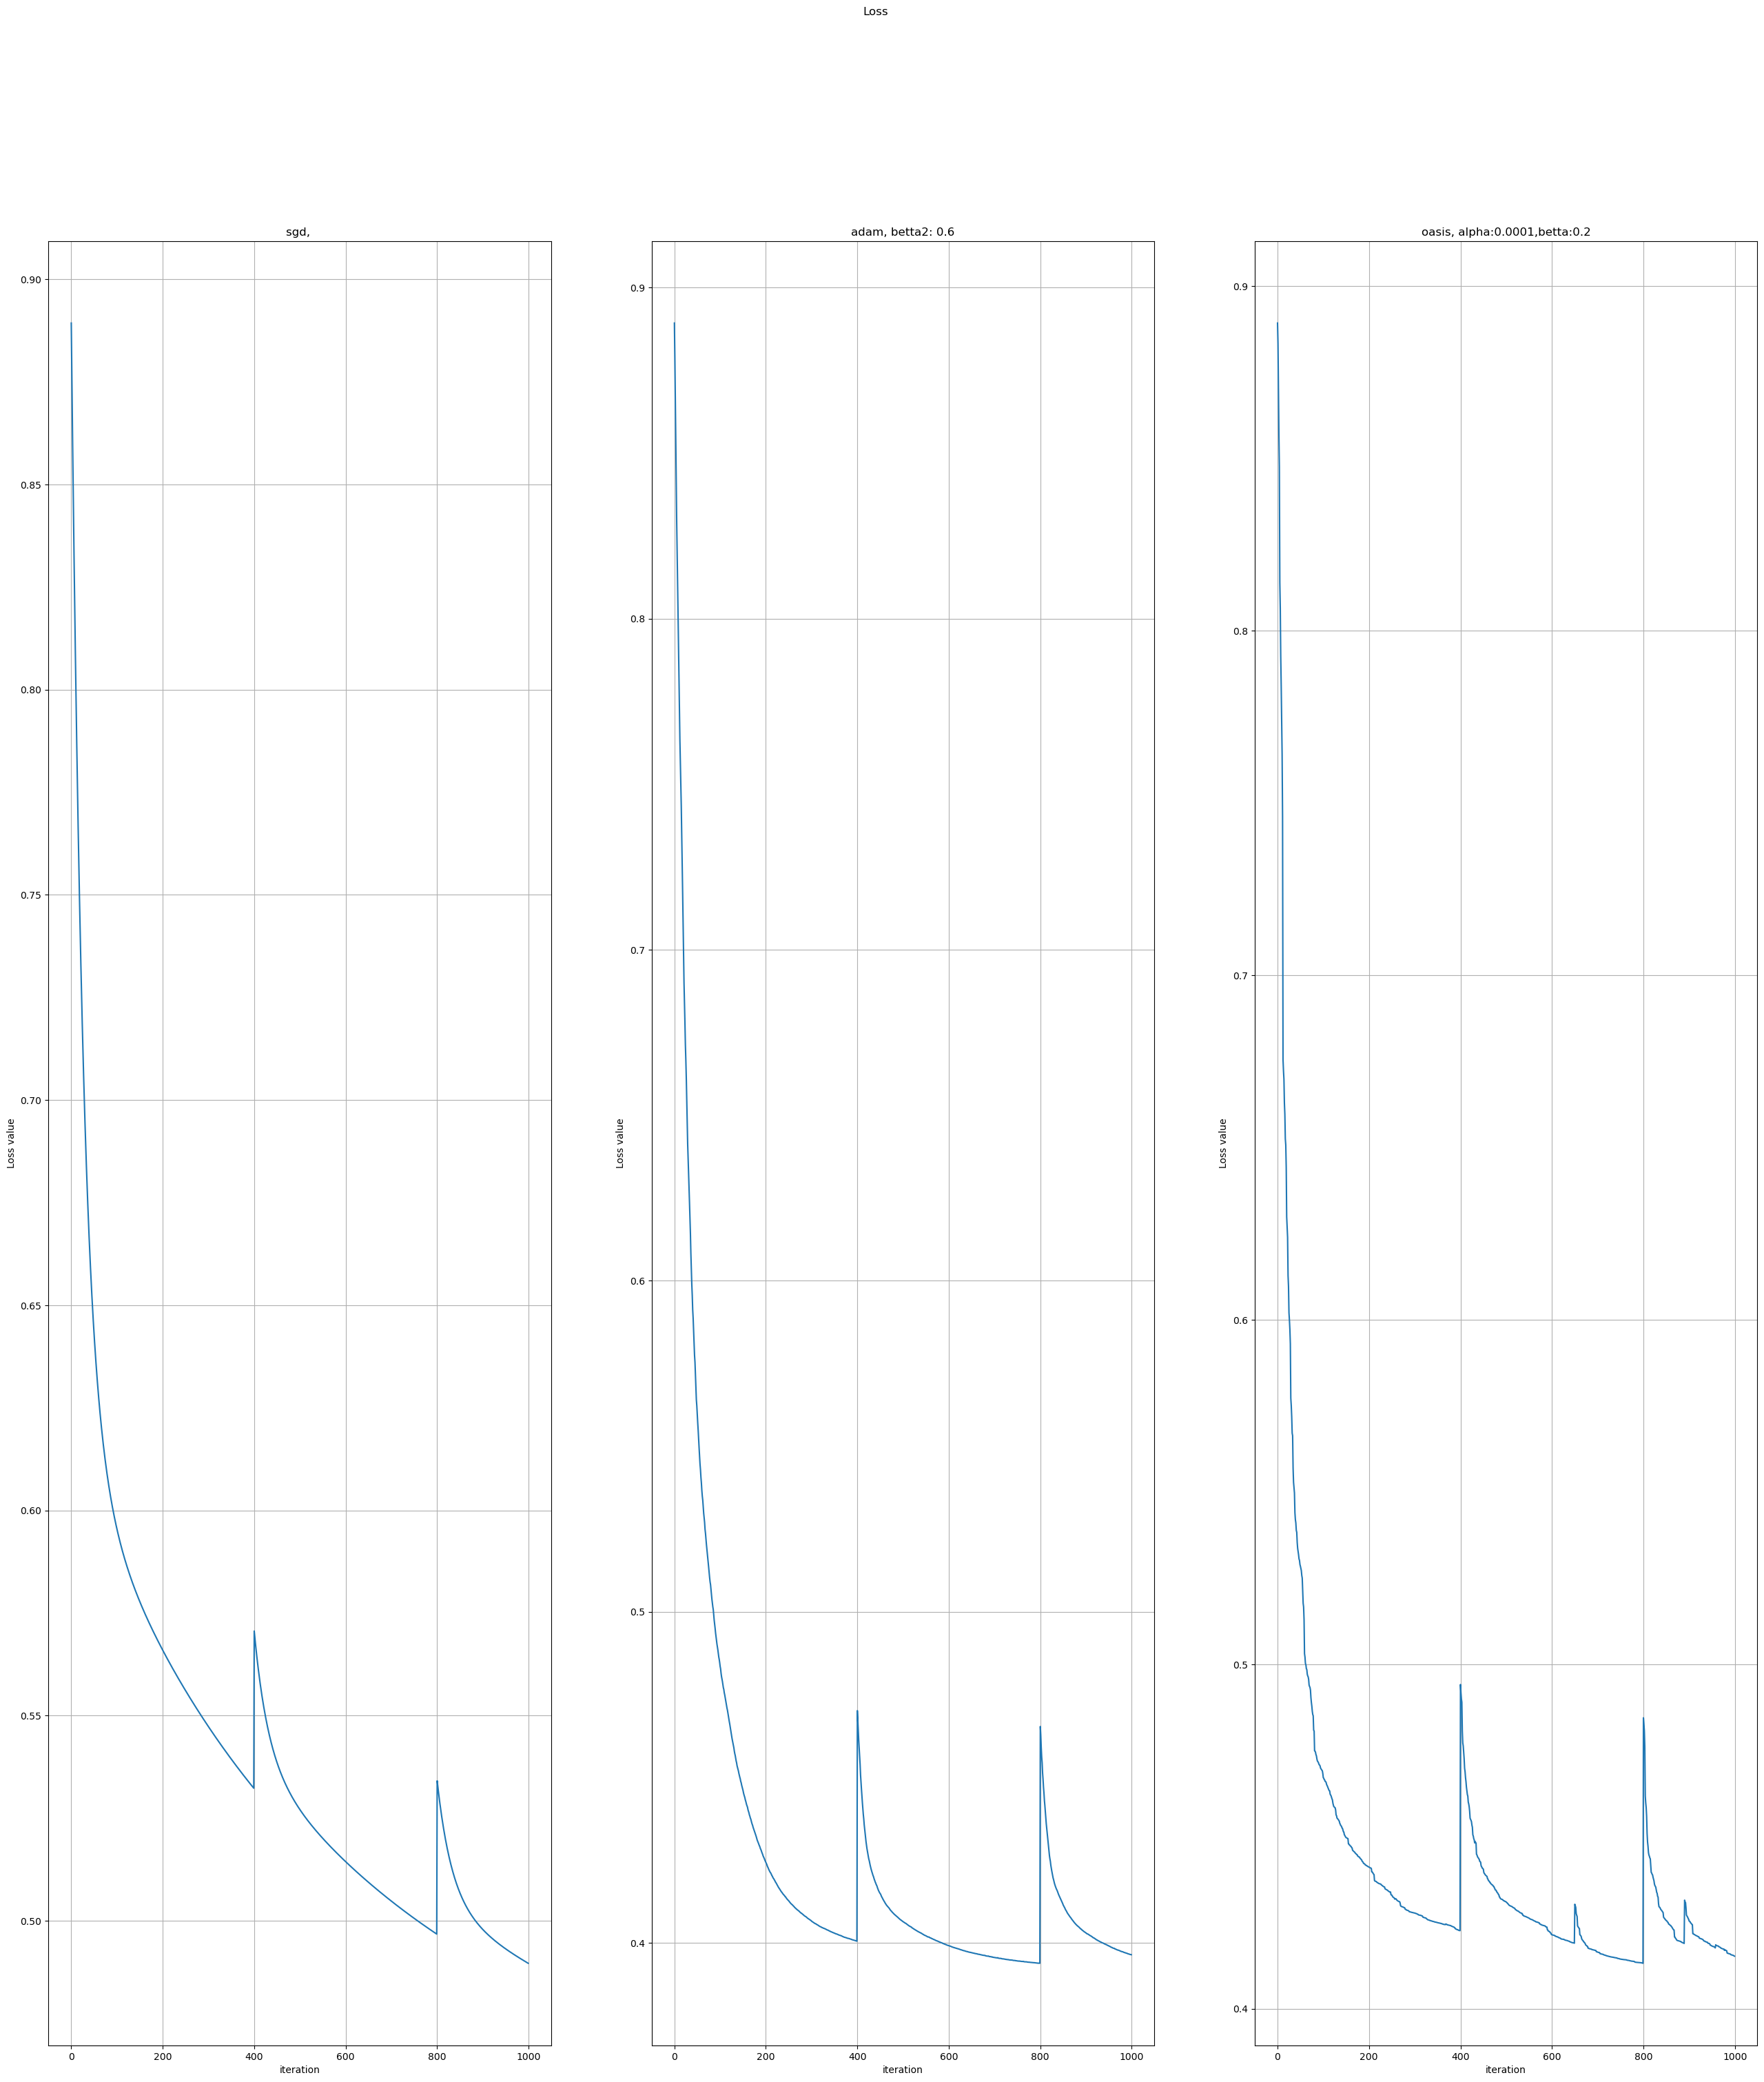

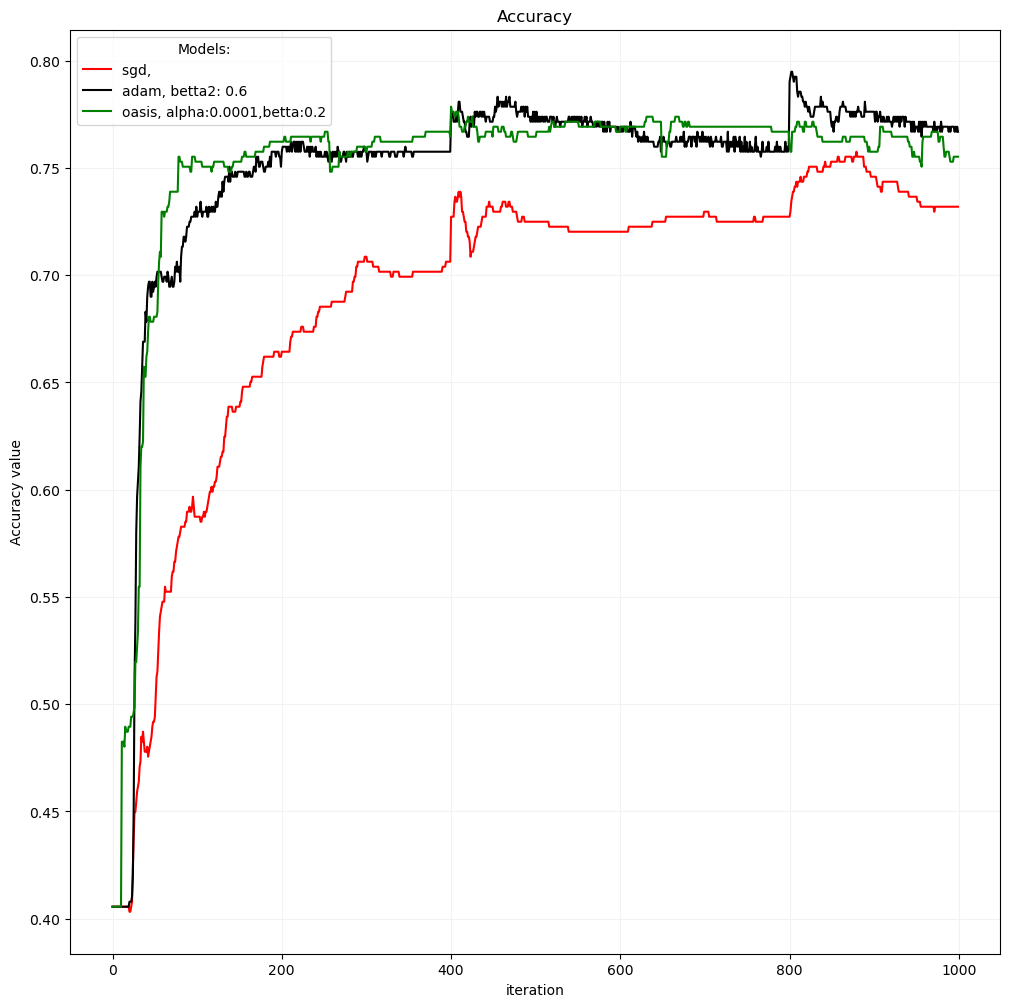

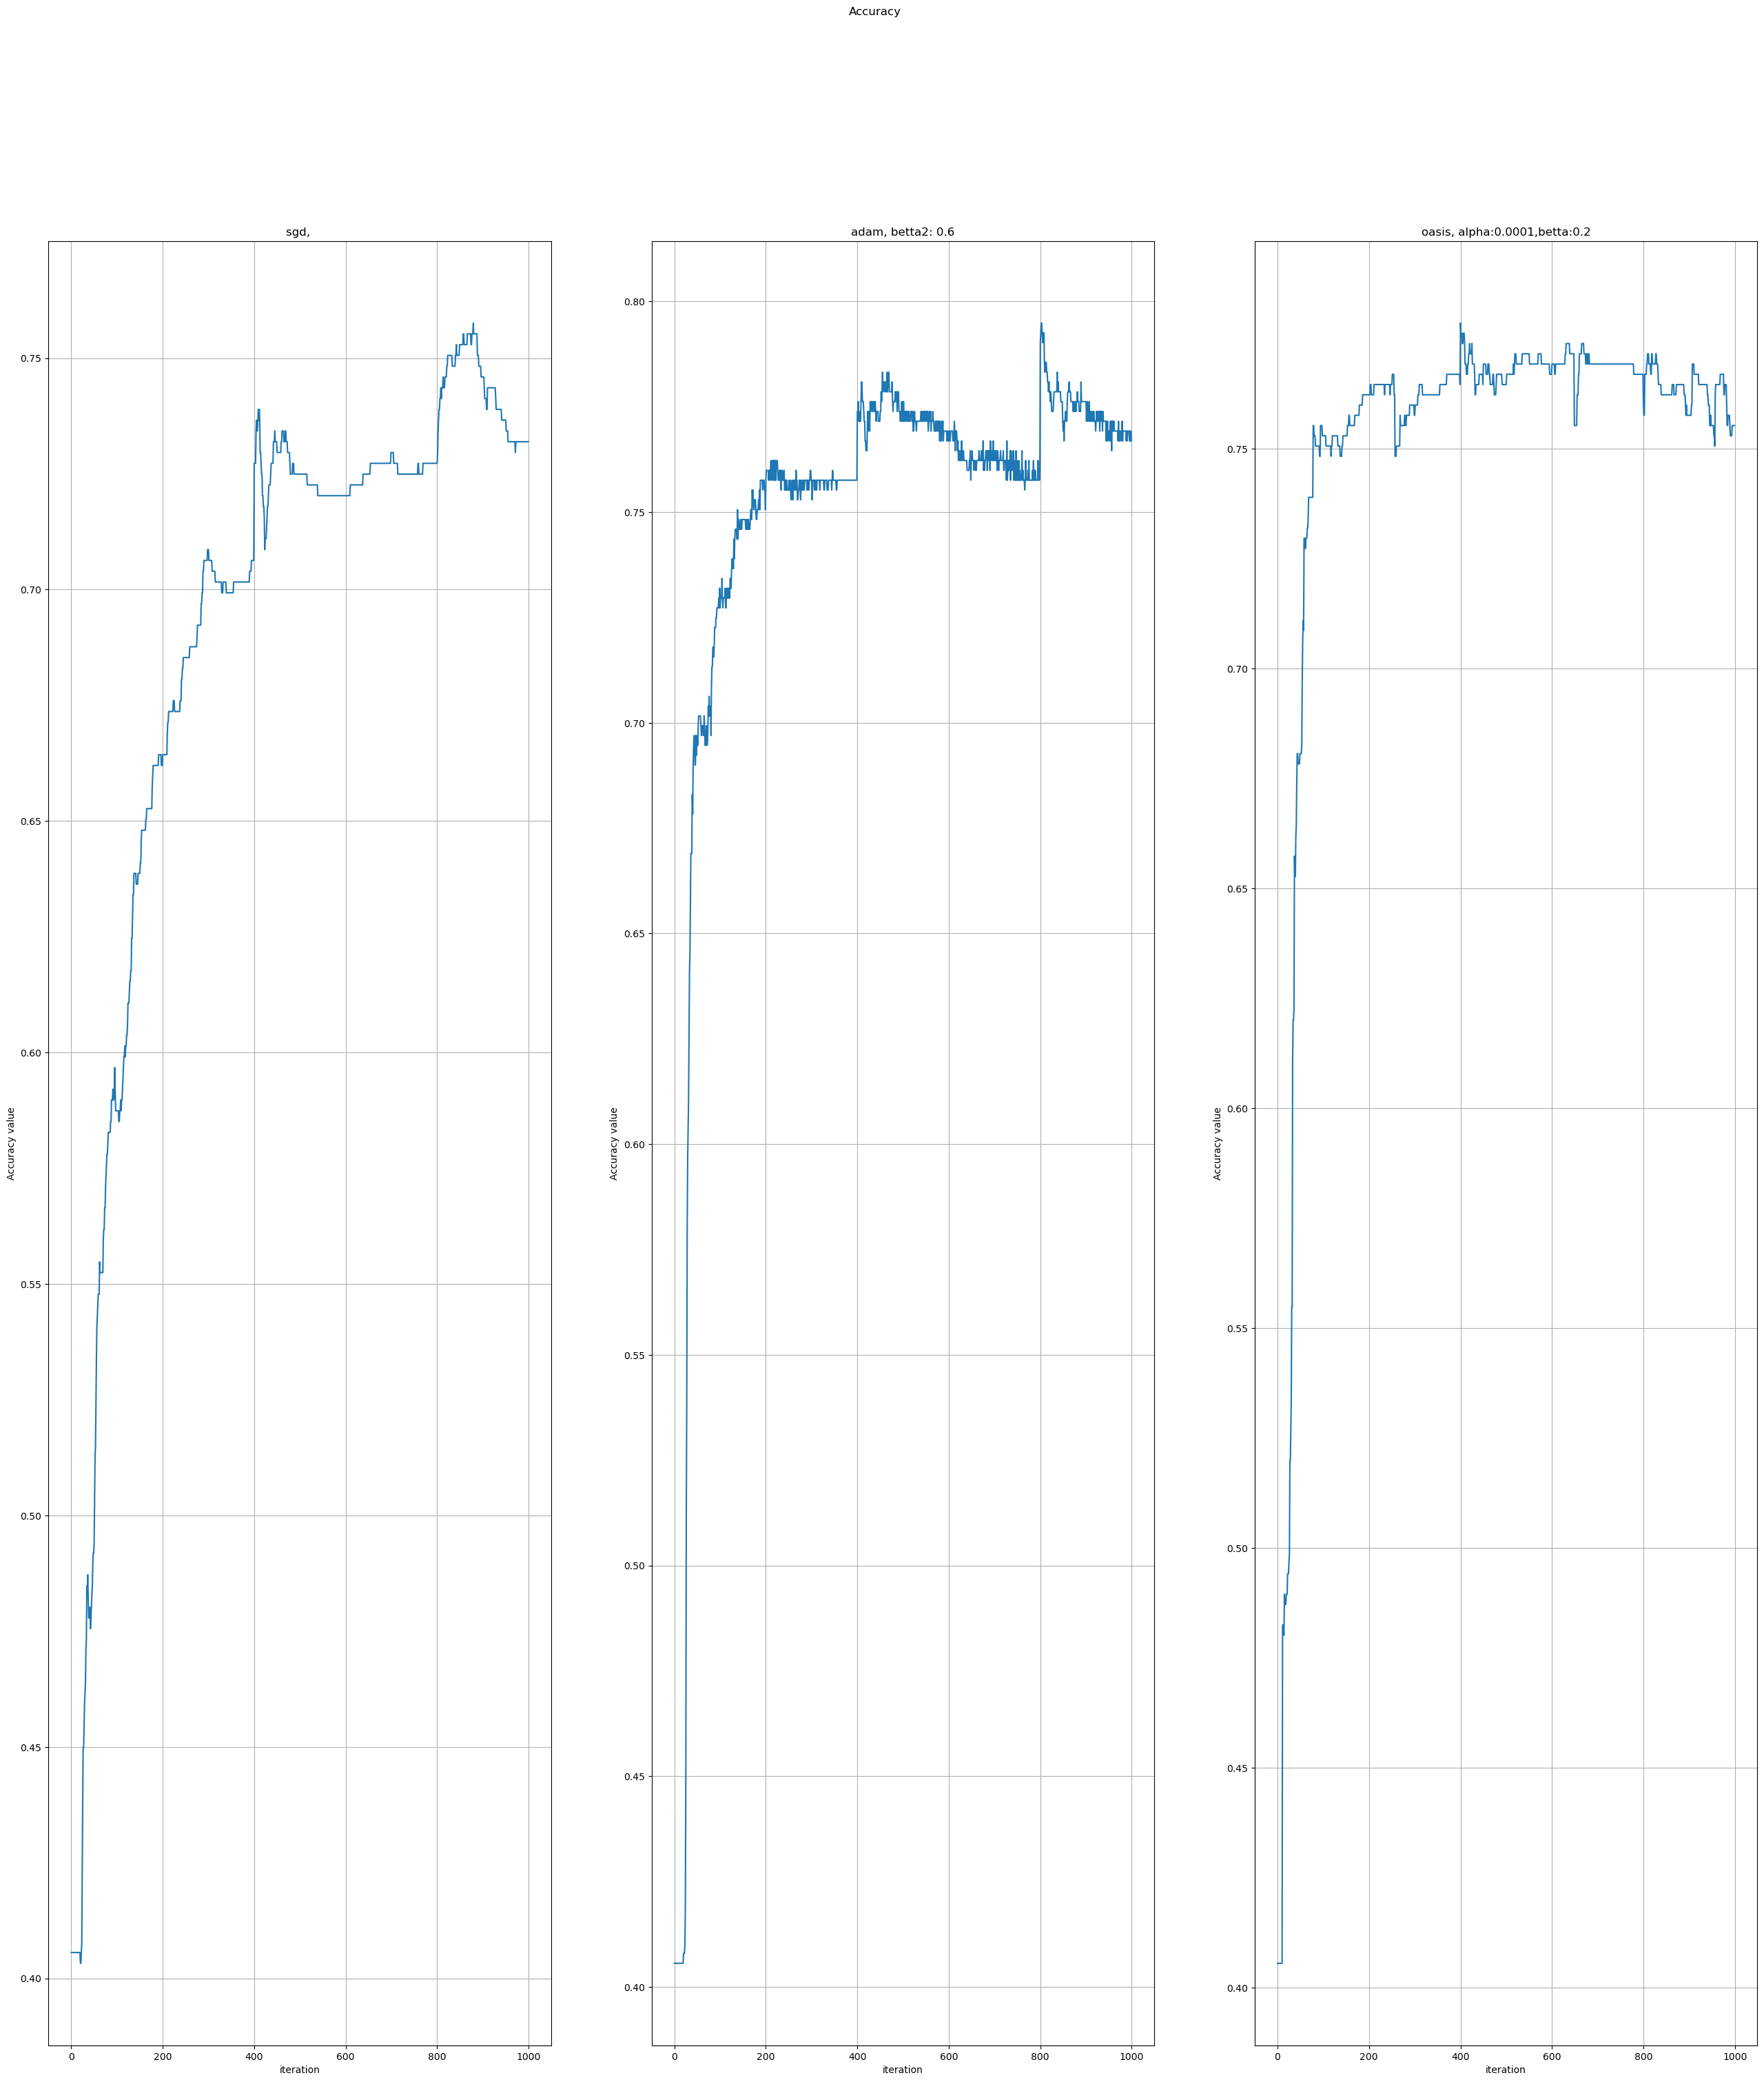

In [36]:
compare_models([r1,r2,r3],1,0,color = ['r','k','g'])